# 基于 NIM 建构多模态 AI-Agent (代码 demo+练习)

本次课程将着重介绍一下内容:

* 多模态模型基于 NIM 的调用方式
* 基于 NIM 接口实现 Phi-3-Vision 的推理实践
* 基于 Gradio 框架建立前端互动界面

## 申请NIM的API Key，来调用NIM的计算资源

进入[ai.nvidia.com](ai.nvidia.com),点击Try Now按钮，选择您要使用的模型并点击，进入后点击**Get API Key**按钮，生成一个秘钥

![](https://v.png.pub/imgs/2024/07/01/72fa333bb5bee55b.png)

# 练习Demo1：基于NIM与langchain实现多模态RAG

### 第一步, 导入工具包

本次实验主要需要三个工具包:

* `langchain_nvidia_ai_endpoint`: 用来调用nvidia nim的计算资源
* `langchain`: 用来构建对话链, 将智能体的各个组件串联起来
* `base64`: 因为本实验是构建多模态的智能体, 需要base64来对图像进行编解码

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.passthrough import RunnableAssign
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables import RunnablePassthrough

from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

import os
import base64
import matplotlib.pyplot as plt
import numpy as np

将上面准备好自己的API-KEY秘钥粘贴在此处进行替换, 当我们向服务器发送计算请求时, 需要用到

In [6]:
#os.environ["NVIDIA_API_KEY"] = "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"
#os.environ["NVIDIA_API_KEY"] = "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"
os.environ["NVIDIA_API_KEY"] = "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"

查看当前可以使用的模型

In [7]:
ChatNVIDIA.get_available_models()

[Model(id='nvidia/usdcode-llama3-70b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='liuhaotian/llava-v1.6-mistral-7b', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/stg/vlm/community/llava16-mistral-7b', aliases=['ai-llava16-mistral-7b', 'community/llava16-mistral-7b', 'liuhaotian/llava16-mistral-7b'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='meta/llama-3.1-405b-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=None, supports_tools=True, supports_structured_output=True, base_model=None),
 Model(id='google/gemma-2-9b-it', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-gemma-2-9b-it'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='ibm/granite-34b-code-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None

### 第二步, 利用Microsoft Phi 3 vision 来解析图片数据

将图片进行编解码

In [8]:
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

image_b64 = image2b64("./test01.png")
# 原始demo代码是image_b64 = image2b64("eco-good-bad-chart.png")

In [9]:
# 下面是自定义的图片png用大模型解析内容
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

image_b64_nvitop = image2b64("./test01.png")    # test01.png图片是nvitop工作负载
image_b64_top = image2b64("./test02.png")       # test02.png图片是top grafana展示的多节点服务器工作负载
image_b64_nvidia_smi = image2b64("./test01.png")    # test03.png图片是nvidia-smi命令查看GPU卡工作负载


查看图片

In [10]:
#from PIL import Image
#display(Image.open("./test.png"))

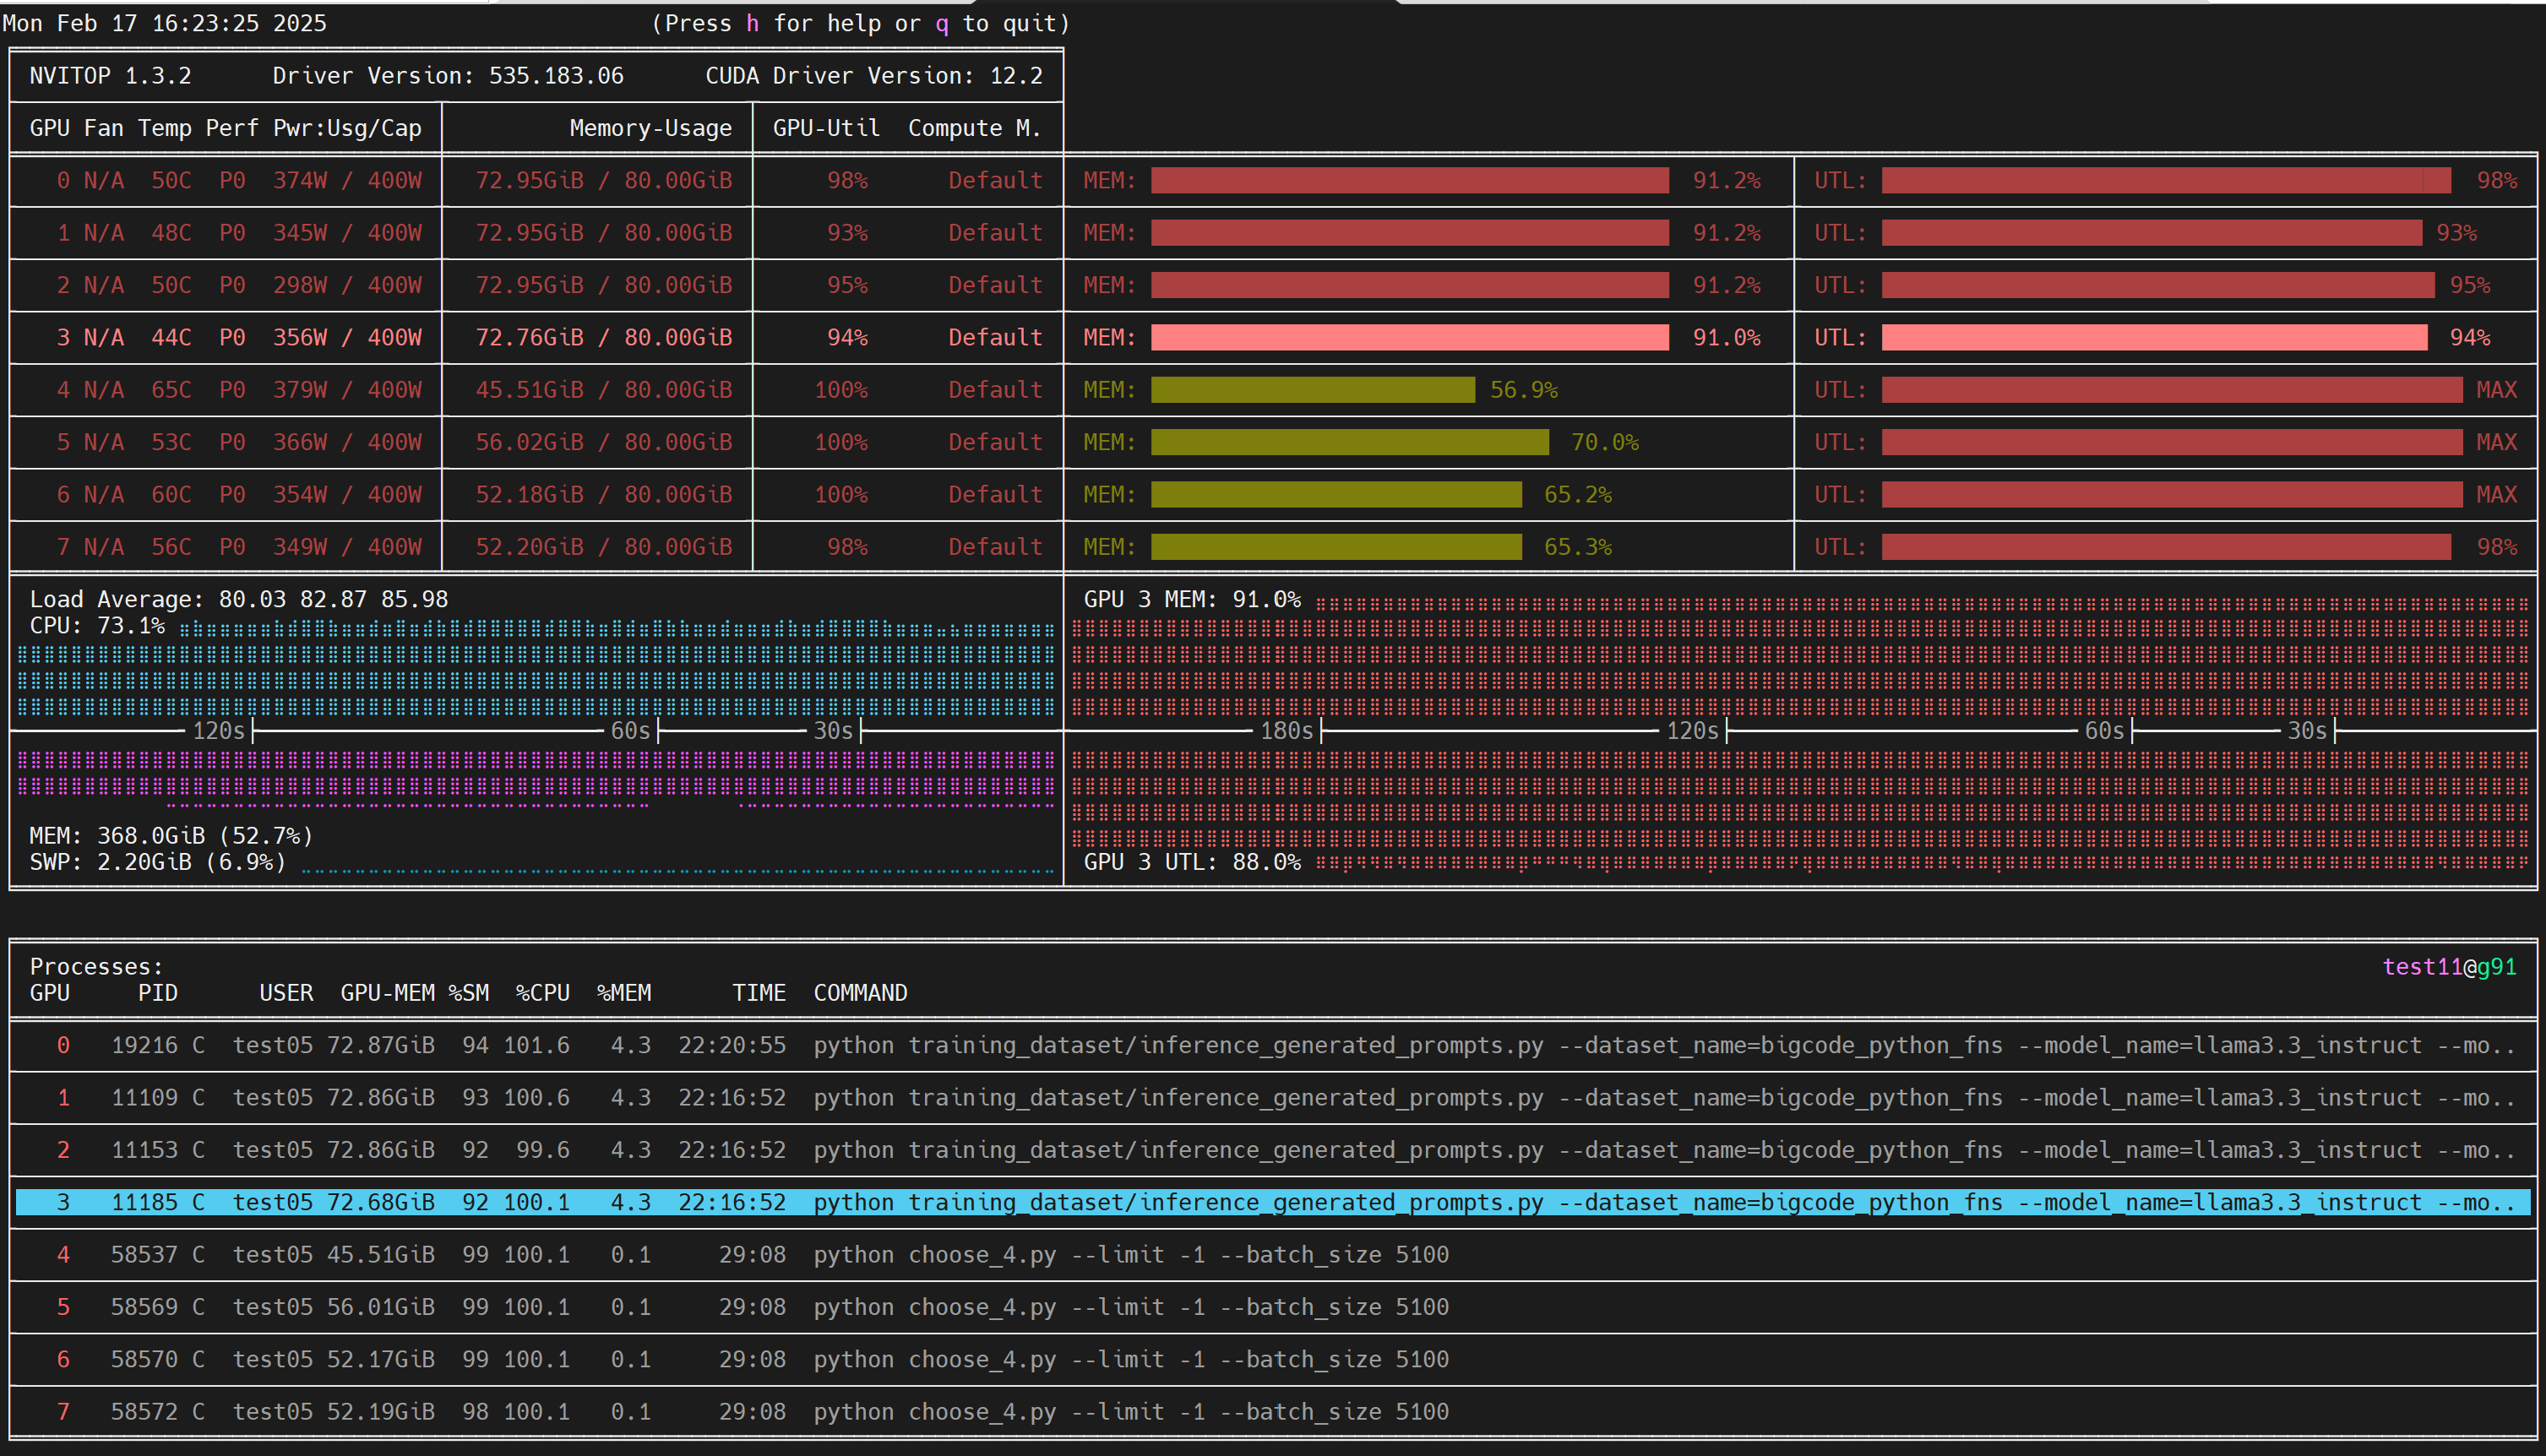

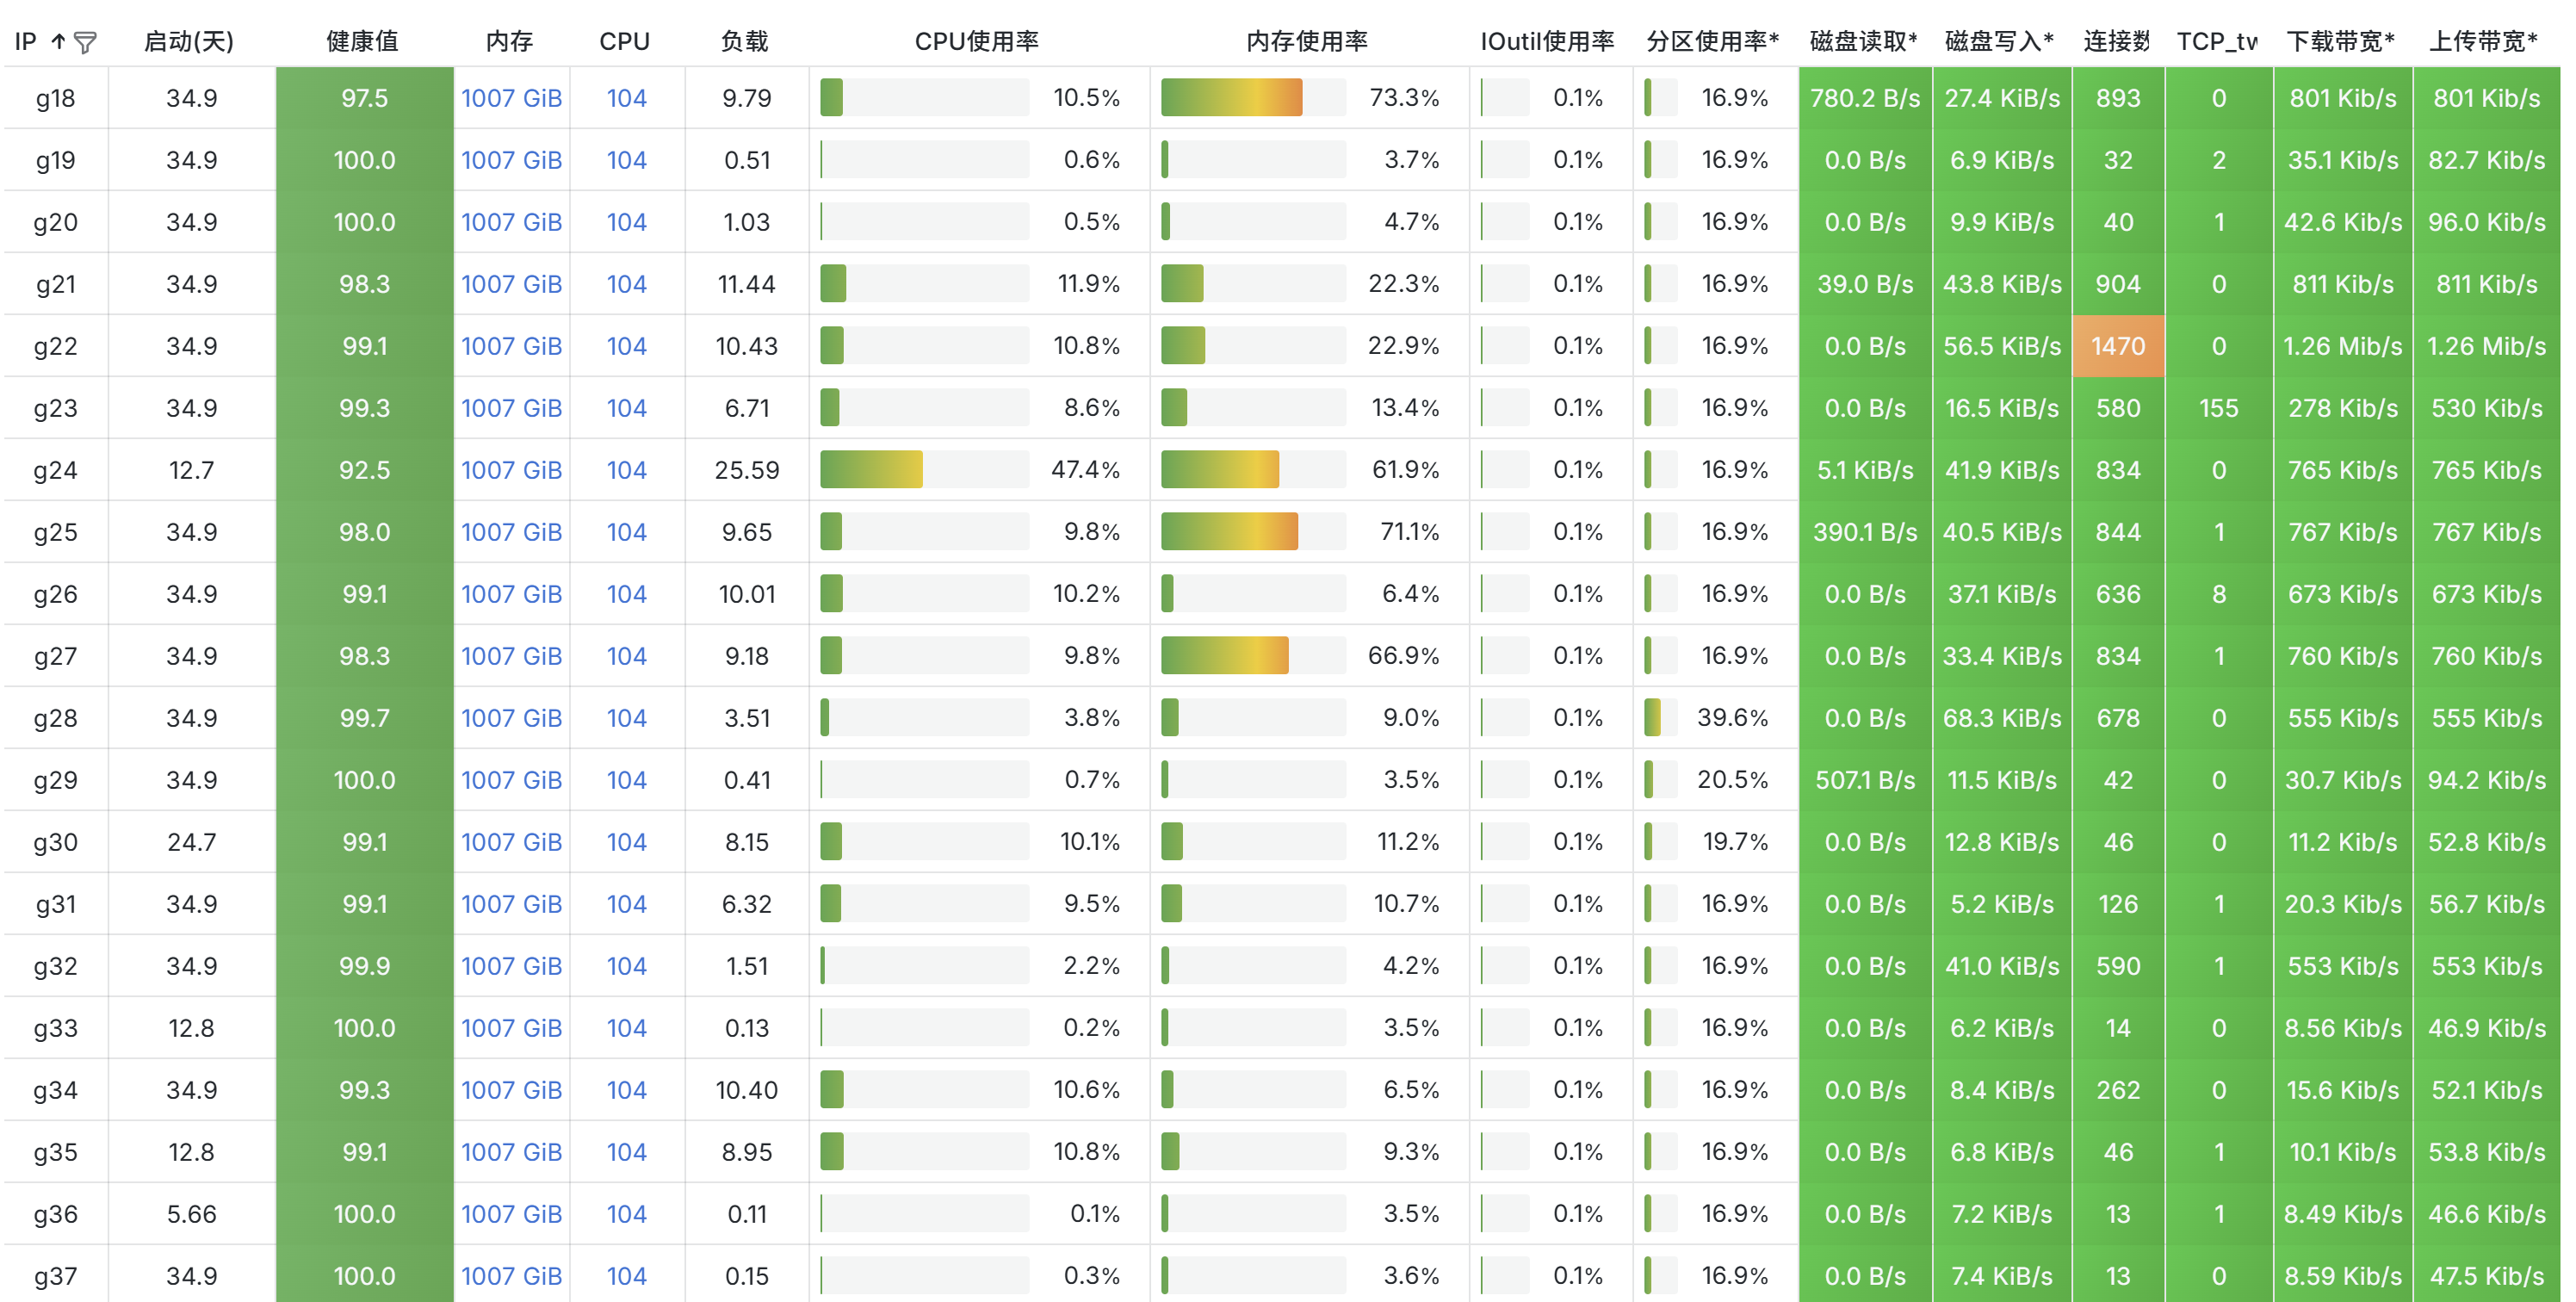

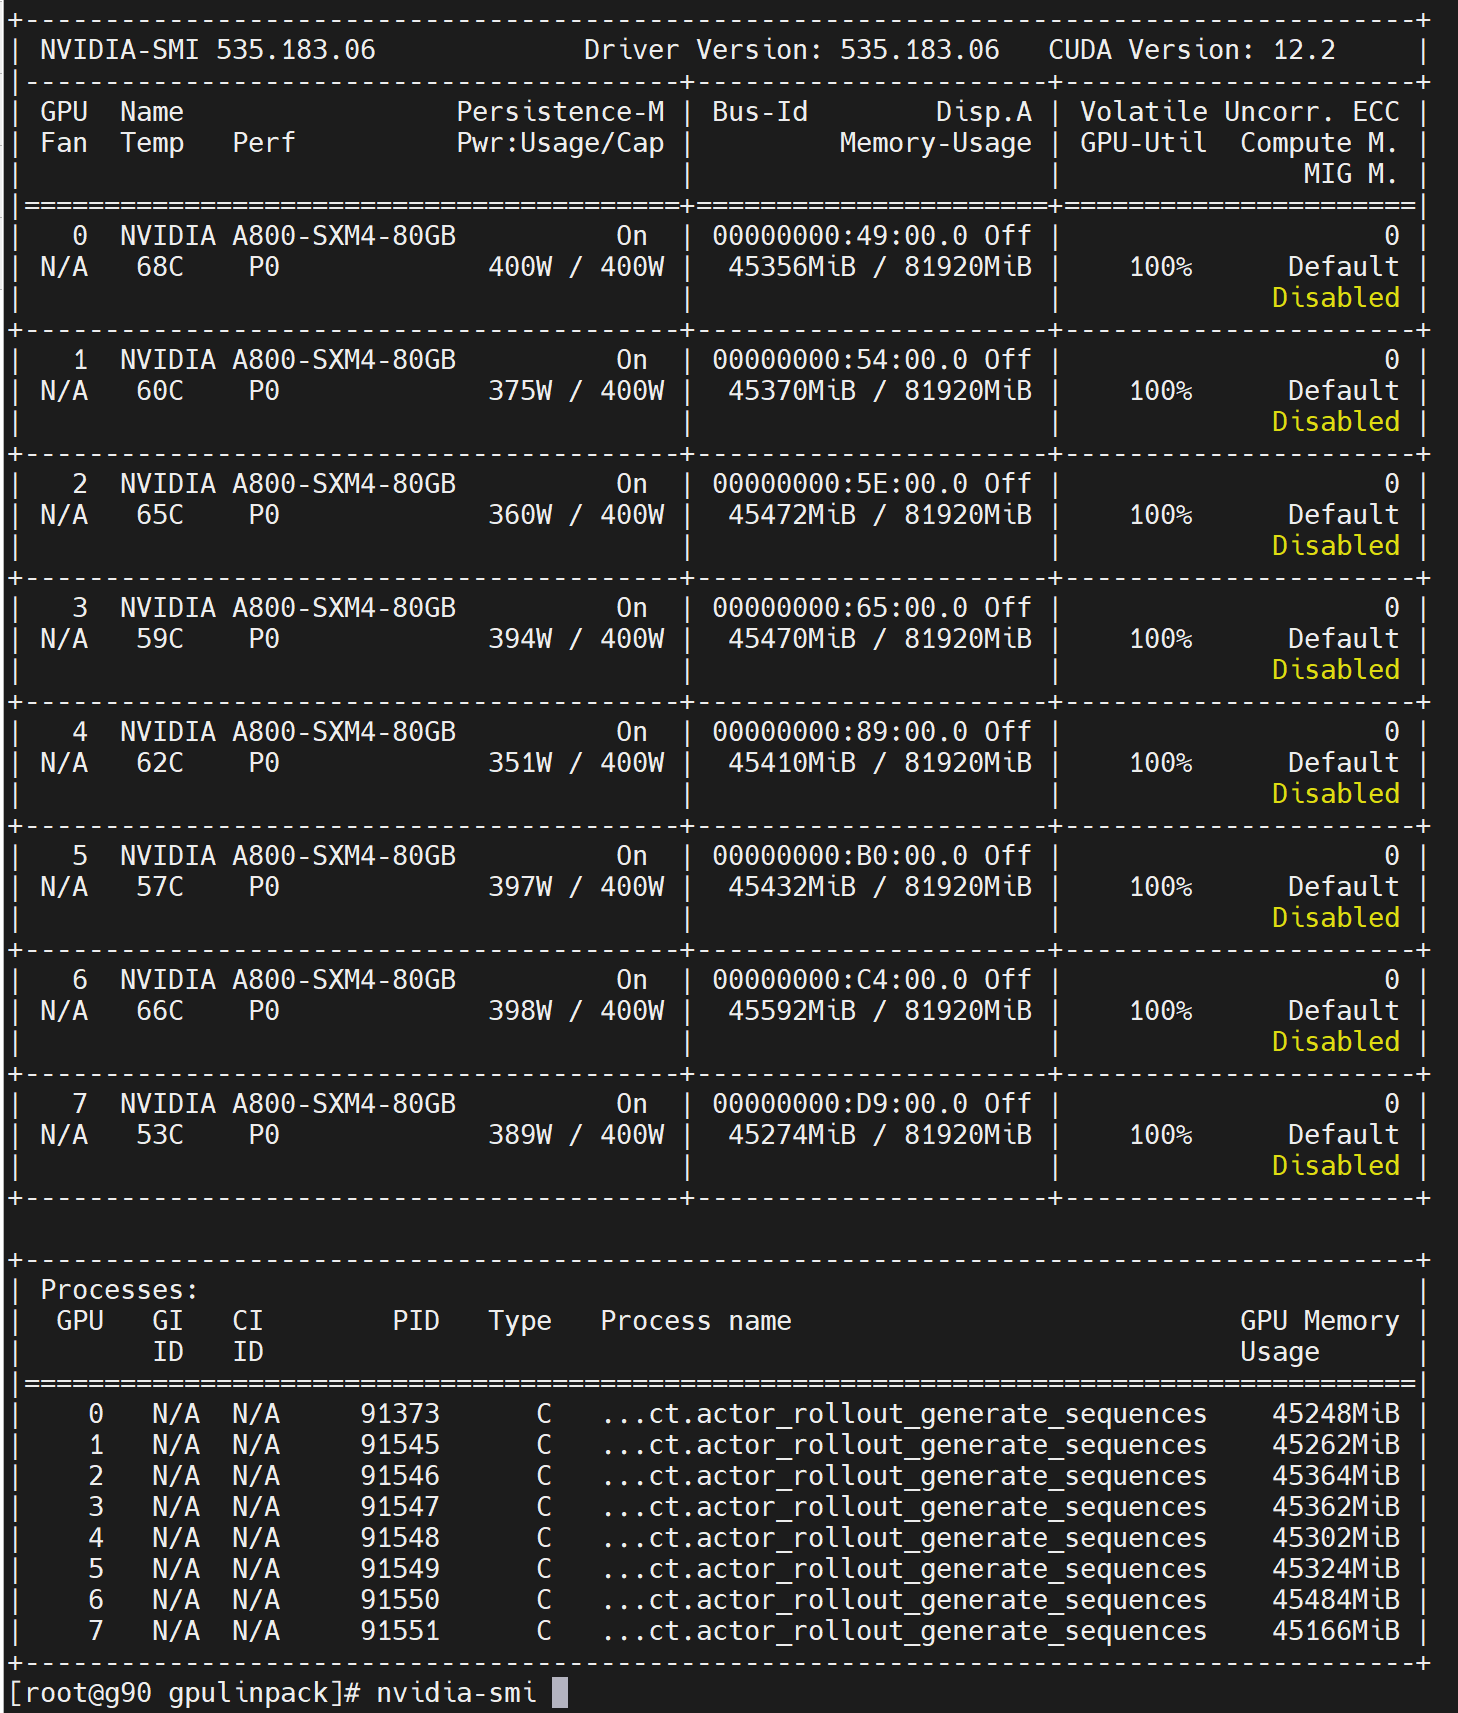

In [7]:
from PIL import Image
display(Image.open("./test01.png"))   #查看nvitop工作负载图片
display(Image.open("./test02.png"))   #查看top工作负载图片
display(Image.open("./test03.png"))   #查看nvidia-smi GPU卡工作负载图片

将编码后的图像按照格式给到Microsoft Phi 3 vision , 利用其强大能力解析图片中的数据

In [8]:
#chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
#chart_reading = ChatNVIDIA(model="ai-phi-3-vision-128k-instruct")
#result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />')
#print(result.content)

In [9]:
# 调用大模型microsoft/phi-3-vision-128k-instruct解析image_b64图片内容
chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")

nvitop_result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_nvitop}" />')
print(nvitop_result.content)
print("###############上面是第1张自定义图片解析内容的分隔符###############")

top_result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_top}" />')
print(top_result.content)
print("###############上面是第2张自定义图片解析内容的分隔符###############")

nvidia_smi_result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_nvidia_smi}" />')
print(nvidia_smi_result.content)
print("###############上面是第3张自定义图片解析内容的分隔符###############")

Certainly, here is the data table in markdown format based on the image provided:

```markdown
| GPU Fan Temp Perf | Pwr:Usage/Cap | Memory-Usage | GPU-Util | Compute M. |
|-------------------|---------------|--------------|----------|------------|
| 0 N/A 50C P0      | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      | Default    |
| 1 N/A 48C P0      | 345W / 400W   | 72.95G1B / 80.00G1B | 93%      | Default    |
| 2 N/A 50C P0      | 298W / 400W   | 72.95G1B / 80.00G1B | 95%      | Default    |
| 3 N/A 44C P0      | 356W / 400W   | 72.76G1B / 80.00G1B | 94%      | Default    |
| 4 N/A 65C P0      | 379W / 400W   | 45.51G1B / 80.00G1B | 100%     | Default    |
| 5 N/A 53C P0      | 366W / 400W   | 56.02G1B / 80.00G1B | 100%     | Default    |
| 6 N/A 60C P0      | 354W / 400W   | 52.18G1B / 80.00G1B | 100%     | Default    |
| 7 N/A 56C P0      | 349W / 400W   | 52.20G1B / 80.00G1B | 98%      | Default    |
```

Additionally, the image contains a section for Load Average, CPU usage, GP

In [10]:
#test_doc = result.content

nvitop_doc = nvitop_result.content
top_doc    = top_result.content
nvidia_smi_doc = nvidia_smi_result.content

In [11]:
#test_doc

nvitop_doc
top_doc
nvidia_smi_doc

'Certainly, here is the data table in markdown format based on the image provided:\n\n```markdown\n| GPU Fan Temp Perf | Pwr:Usage/Cap | Memory-Usage | GPU-Util | Compute M. |\n|-------------------|---------------|--------------|----------|------------|\n| 0 N/A 50C P0      | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      | Default    |\n| 1 N/A 48C P0      | 345W / 400W   | 72.95G1B / 80.00G1B | 93%      | Default    |\n| 2 N/A 50C P0      | 298W / 400W   | 72.95G1B / 80.00G1B | 95%      | Default    |\n| 3 N/A 44C P0      | 356W / 400W   | 72.76G1B / 80.00G1B | 94%      | Default    |\n| 4 N/A 65C P0      | 379W / 400W   | 45.51G1B / 80.00G1B | 100%     | Default    |\n| 5 N/A 53C P0      | 366W / 400W   | 56.02G1B / 80.00G1B | 100%     | Default    |\n| 6 N/A 60C P0      | 354W / 400W   | 52.18G1B / 80.00G1B | 100%     | Default    |\n| 7 N/A 56C P0      | 349W / 400W   | 52.20G1B / 80.00G1B | 98%      | Default    |\n```\n\nAdditionally, the image contains a section for Load Averag

In [12]:
#with open('./example.txt', 'w', encoding='utf-8') as file:
#    # 将字符串写入文件
#    file.write(test_doc)
#
#print("字符串已写入文件。")

In [3]:
with open('./nvitop.txt', 'w', encoding='utf-8') as file:
    # 将字符串写入文件
    file.write(nvitop_doc)
print("nvitop字符串已写入文件。")


with open('./top.txt', 'w', encoding='utf-8') as file:
    # 将字符串写入文件
    file.write(top_doc)
print("top grafana图片解析内容字符串已写入文件。")


with open('./nvidia_smi.txt', 'w', encoding='utf-8') as file:
    # 将字符串写入文件
    file.write(nvidia_smi_doc)
print("nvidia-smi解析内容字符串已写入文件。")



NameError: name 'nvitop_doc' is not defined

### 第三步, 实现RAG检索流程

In [7]:
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

In [8]:
import os              #导入os模块，该模块提供了与操作系统进行交互的功能，比如文件和目录操作。
from tqdm import tqdm    #导入tqdm库中的tqdm函数，tqdm可以在循环中显示进度条，让用户直观地了解循环的执行进度。
from pathlib import Path   #导入pathlib模块中的Path类，Path类提供了一种面向对象的方式来处理文件系统路径。

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("./")    #使用os.listdir()函数获取当前目录（.表示当前目录）下的所有文件和文件夹的名称，并将这些名称存储在列表ps中
data = []     # 创建一个空列表data，用于存储从文本文件中读取的所有有效行。
sources = []  # 创建一个空列表sources，用于存储每一行数据对应的文件路径。
for p in ps:  # 遍历列表ps中的每个文件或文件夹名称
    if p.endswith('.txt'):  # 检查当前文件或文件夹名称是否以.txt结尾，如果是，则表示这是一个文本文件，需要进行处理。
        path2file="./"+p    # 构建当前文本文件的完整路径，将当前目录（./）和文件名拼接起来。
        with open(path2file,encoding="utf-8") as f:  # 使用open()函数以 UTF - 8 编码打开当前文本文件，并将文件对象赋值给变量f。with语句会在文件使用完毕后自动关闭文件。
            lines=f.readlines()  # 使用readlines()方法读取文件中的所有行，并将这些行存储在列表lines中。 
            for line in lines:   # 遍历列表lines中的每一行。
                if len(line)>=1:  # 检查当前行的长度是否大于等于 1，如果是，则表示这是一个有效行。
                    data.append(line)  # 将有效行添加到列表data中。
                    sources.append(path2file)  # 将当前行对应的文件路径添加到列表sources中。

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [16]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0],data[-1]
# 这行代码实际上是一个元组，它分别计算了列表 data 的长度、列表 documents 的长度，并且获取了列表 data 的第一个元素,data 的最后一个元素。

(991,
 980,
 'Certainly, here is the data table in markdown format based on the image provided:\n',
 '| g25    | 34.9     | 98.0   | 1007 GiB |')

In [17]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings #langchain_nvidia_ai_endpoints 是一个自定义的 Python 模块，可能是由 NVIDIA 相关团队开发并集成到 langchain 生态系统中的。langchain 是一个用于开发由语言模型驱动的应用程序的框架，支持各种语言模型和工具的集成。NVIDIAEmbeddings 是从 langchain_nvidia_ai_endpoints 模块中导入的一个类。这个类通常用于将文本数据转换为向量表示，也就是文本嵌入（embeddings）。文本嵌入是将文本转换为数值向量的过程，这些向量可以用于各种自然语言处理任务，如文本相似度计算、信息检索、聚类等。

#embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")
embedder = NVIDIAEmbeddings(model="NV-Embed-QA")  #是传递给 NVIDIAEmbeddings 类构造函数的一个参数，它指定了要使用的嵌入模型。NV-Embed-QA 是 NVIDIA 提供的一个专门用于问答任务（QA，Question - Answering）的嵌入模型。当你调用 embedder 对象的相关方法时，它会使用 NV-Embed-QA 模型将输入的文本转换为对应的向量表示。

In [18]:
# 只需要执行一次，后面可以重读已经保存的向量存储
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
# CharacterTextSplitter 是 langchain 库中用于按字符进行文本分割的工具类。
# chunk_size=400：指定每个分割块的最大字符数为 400。即文本会被分割成字符数不超过 400 的小块。
# separator=" "：指定分割文本时使用的分隔符为空格。当分割文本时，会尽量以空格为界限来划分出不超过 400 字符的块。
docs = []  # docs：用于存储分割后的文本块。
metadatas = []  # metadatas：用于存储每个文本块对应的元数据，这里的元数据主要是文本块的来源信息。

for i, d in enumerate(documents):          # 使用 enumerate 函数遍历 documents 列表，i 是当前文档的索引，d 是当前文档的内容。
    splits = text_splitter.split_text(d)   # 调用 text_splitter 的 split_text 方法，将当前文档 d 分割成多个小块，结果存储在 splits 列表中。
    #print(len(splits))
    docs.extend(splits)    # 将分割后的文本块添加到 docs 列表中。
    metadatas.extend([{"source": sources[i]}] * len(splits))  # 为每个分割后的文本块生成对应的元数据，元数据是一个字典，键为 "source"，值为该文本块原始文档的来源（存储在 sources 列表中）。[{"source": sources[i]}] * len(splits) 会生成与分割后的文本块数量相同的元数据列表，然后将其添加到 metadatas 列表中。

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)   
store.save_local('./nv_embedding')

# FAISS 是一个用于高效相似性搜索和聚类的开源库，这里使用 langchain 对其进行了封装。
# FAISS.from_texts 是一个类方法，用于从文本列表构建 FAISS 向量索引。
# docs：输入的文本列表，即分割后的文本块。
# embedder：之前创建的嵌入器实例，用于将文本转换为向量表示。
# metadatas：每个文本块对应的元数据列表。
# 调用 store 对象的 save_local 方法，将构建好的 FAISS 向量索引保存到本地的 ./nv_embedding 目录下。后续可以从该目录加载索引进行相似性搜索等操作。
# 综上所述，这段代码的整体作用是将原始文本数据进行分割、向量化，并构建向量索引保存到本地，以便后续进行高效的文本搜索和检索。


In [19]:
#llm = ChatNVIDIA(model="ai-llama3-70b")
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

# 这行代码的主要功能是创建一个基于 NVIDIA 相关技术的大语言模型实例 llm，并且指定使用的具体模型为 "meta/llama3-70b-instruct"。该实例可以用于后续的文本生成、问答等自然语言处理任务。
# model="meta/llama3-70b-instruct" 参数
# model：这是传递给 ChatNVIDIA 类构造函数的一个重要参数，用于指定要使用的具体大语言模型。
# "meta/llama3-70b-instruct"：
# "meta" 通常表示该模型由 Meta（原 Facebook）公司开发。Meta 在自然语言处理领域有诸多研究和贡献，开发了许多知名的大语言模型。
# "llama3" 表明使用的是 Llama 系列的第三代模型。Llama 模型以其强大的语言理解和生成能力而受到广泛关注。
# "70b" 代表该模型具有 700 亿个参数。一般来说，模型的参数数量越多，其学习能力和表达能力就越强，能够处理更复杂的语言任务和生成更高质量的文本。
# "instruct" 说明这是一个经过指令微调的模型。经过指令微调的模型能够更好地理解用户以指令形式给出的任务描述，并按照指令生成相应的输出，例如回答问题、完成文本续写、进行文本摘要等。

In [20]:
# 创建检索器
retriever = store.as_retriever()
# store 是之前使用 FAISS.from_texts 方法构建的向量索引对象。
# as_retriever() 是 store 对象的一个方法，它将向量索引转换为一个检索器 retriever。检索器的作用是根据输入的查询文本，在向量索引中查找与之最相似的文本块。

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)
# ChatPromptTemplate 是 langchain 库中用于创建聊天提示模板的类。
# from_messages 是该类的一个类方法，用于从消息列表创建提示模板。消息列表中的每个元素是一个元组，包含消息的角色（如 "system" 或 "user"）和消息内容。
# "system" 消息是系统级别的提示信息，告诉大语言模型回答问题时仅基于提供的上下文信息。{context} 是一个占位符，后续会被检索到的相关文本块填充。
# "user" 消息是用户提出的问题，{question} 是一个占位符，会被实际的问题文本替换。



chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
# 这里使用了 langchain 的链式调用语法，将多个组件组合成一个处理链。
# {"context": retriever, "question": RunnablePassthrough()}：这是一个字典，用于将输入数据进行分发。"context" 键对应的值是 retriever，表示将输入的问题传递给检索器，检索器会返回相关的文本块作为上下文；"question" 键对应的值是 RunnablePassthrough()，表示将输入的问题原样传递下去。
# | prompt：将分发后的数据传递给提示模板 prompt，提示模板会根据占位符 {context} 和 {question} 填充相应的内容，生成完整的提示信息。
# | llm：将填充好的提示信息传递给大语言模型 llm，大语言模型根据提示信息生成答案。
# | StrOutputParser()：将大语言模型生成的输出解析为字符串类型。


#chain.invoke("Malaysia 2023 Growth？")
#chain.invoke("China 2023 Growth？")
#chain.invoke("Indonesia 2023 Growth？")
#chain.invoke("g18 节点的内存使用率是多少？")
#chain.invoke("What is the CPU usage rate of node g18?")
chain.invoke("Which command belongs to test05?")
# invoke 是处理链 chain 的一个方法，用于启动整个处理流程。
#传入的 "China 2023 Growth？" 是用户提出的问题，处理链会先使用检索器查找相关的上下文，然后将上下文和问题填充到提示模板中，再将提示信息传递给大语言模型生成答案，最后将答案解析为字符串并返回。
# 综上所述，这段代码实现了一个完整的问答系统，利用向量索引检索相关信息，结合大语言模型生成基于上下文的问题答案。

# 这段代码主要实现了一个基于检索增强生成（RAG）的问答系统，利用之前构建的向量索引来检索相关信息，并结合大语言模型生成问题的答案。

"The command that belongs to test05 is:\n\n`python training_dataset/inference_generated_prompts.py --dataset_name=bigcode_python_fns --model_name=llama3.3_instruct --`\n\nThis command appears in the page_content of two documents, both of which have 'test05' in their page_content."

# 练习Demo2,基于NIM与LangChain 构建多模态智能体

**Agent 应用场景**：将图片中的统计图表转换为可以用 python 进行分析的数据

**Agent 工作流**：
- 接收图片，读取图片数据
- 对数据进行调整、分析
- 生成能够绘制图片的代码,并执行代码
- 根据处理后的数据绘制图表

**接收图片 -> 分析数据 -> 修改数据 -> 生成绘制图片的代码 -> 执行代码 -> 展示结果**

#### 辅助函数

这里的函数用于显示输入, 执行代码等, 在我们执行过程中可能会用到

In [21]:
import re
# re 是 Python 的正则表达式模块，用于处理和匹配字符串模式。在这段代码中，它主要用于从大模型生成的文本里提取 Python 代码。


# 将 langchain 运行状态下的表保存到全局变量中
def save_table_to_global(x):
    global table
    if 'TABLE' in x.content:
        table = x.content.split('TABLE', 1)[1].split('END_TABLE')[0]
    return x
# 功能：该函数的作用是将包含在 x.content 里的表格内容提取出来并保存到全局变量 table 中。
# 详细解释：
# global table：声明 table 为全局变量，这样在函数内部对 table 赋值时会影响到全局作用域中的 table 变量。
# if 'TABLE' in x.content:：检查 x.content 中是否包含 TABLE 字符串。
# table = x.content.split('TABLE', 1)[1].split('END_TABLE')[0]：如果包含 TABLE，则先以 TABLE 为分隔符将字符串分割，取分割后的第二部分，再以 END_TABLE 为分隔符进行分割，取分割后的第一部分，这部分就是表格内容，将其赋值给全局变量 table。
# return x：最后返回原始的 x 对象。
    

# helper function 用于Debug
def print_and_return(x):
    print(x)
    return x
# 功能：该函数主要用于调试，它会打印输入的对象 x，然后再将 x 返回。这样在链式调用中可以方便地查看中间结果。
    

# 对大模型生成的代码进行处理, 将注释或解释性文字去除掉, 留下pyhon代码
def extract_python_code(text):
    pattern = r'```python\s*(.*?)\s*```'
    matches = re.findall(pattern, text, re.DOTALL)
    return [match.strip() for match in matches]
# 功能：从输入的文本中提取用 Markdown 代码块格式包裹的 Python 代码。
# 详细解释：
# pattern = r'```python\s*(.*?)\s*```'：定义一个正则表达式模式，用于匹配以 python` 开头、以 结尾的代码块。(.*?) 是一个非贪婪匹配，用于捕获代码块中的内容。
# matches = re.findall(pattern, text, re.DOTALL)：使用 re.findall 函数在 text 中查找所有匹配该模式的内容。re.DOTALL 标志使得 . 可以匹配任意字符，包括换行符。
# return [match.strip() for match in matches]：将匹配到的内容去除首尾空白字符后组成一个列表并返回。

    

# 执行由大模型生成的代码
def execute_and_return(x):
    code = extract_python_code(x.content)[0]
    try:
        result = exec(str(code))
        #print("exec result: "+result)
    except ExceptionType:
        print("The code is not executable, don't give up, try again!")
    return x
# 功能：执行从大模型生成的文本中提取的 Python 代码。
# 详细解释：
# code = extract_python_code(x.content)[0]：调用 extract_python_code 函数从 x.content 中提取 Python 代码，并取第一个匹配结果。
# try: ... except ExceptionType:：使用 try-except 语句捕获代码执行过程中可能出现的异常。不过 ExceptionType 在这里应该是一个错误，通常应该使用具体的异常类型，如 Exception 来捕获所有异常。
# result = exec(str(code))：使用 exec 函数执行提取到的 Python 代码。exec 函数用于执行动态创建的 Python 代码，它返回值通常为 None。
# print("The code is not executable, don't give up, try again!")：如果代码执行过程中出现异常，打印提示信息。
# return x：最后返回原始的 x 对象
    
import base64
# 将图片编码成base64格式, 以方便输入给大模型
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

# 功能：将指定路径的图片文件编码为 Base64 字符串。
# 详细解释：
# with open(image_file, "rb") as f:：以二进制只读模式打开图片文件。
# image_b64 = base64.b64encode(f.read()).decode()：读取文件内容，使用 base64.b64encode 函数将其编码为 Base64 字节串，再使用 decode 方法将字节串转换为字符串。
# return image_b64：返回编码后的 Base64 字符串。
# 综上所述，这段代码主要提供了一系列工具函数，用于处理大模型生成的文本和图片，包括提取表格、提取 Python 代码、执行代码以及将图片编码为 Base64 格式等操作。

### 定义多模态数据分析 Agent

* 这里首先定义了提示词模板, chart_reading_prompt, 我们输入的图片会变成base64格式的string传输给它
* 将处理好的提示词输入给char_reading, 也就是microsoft/phi-3-vision大模型来进行数据分析, 得到我们需要的表格或者说table变量
* 将Phi3 vision处理好的table和提示词输入给另一个大模型llama3.1, 修改数据并生成代码
* 将生成的代码通过上面的执行函数来执行python代码, 并得到结果

In [22]:
# chart_agent 函数是一个综合性的智能代理函数，其主要目的是处理包含图表和文本需求的用户输入。
# 它会根据是否已有图表数据表格，决定是否调用视觉模型读取图表生成表格数据，然后结合表格数据和用户需求，通过指令式大语言模型生成响应，并对响应中的表格和代码进行处理和执行。

def chart_agent(image_b64, user_input, table):
    # Chart reading Runnable
    #chart_reading = ChatNVIDIA(model="ai-phi-3-vision-128k-instruct")
    chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
    chart_reading_prompt = ChatPromptTemplate.from_template(
        #'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_nvitop}" />'
         'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />'
    )
    chart_chain = chart_reading_prompt | chart_reading
# 模型选择：使用 ChatNVIDIA 类实例化一个视觉大语言模型 chart_reading，这里选择的是 microsoft/phi-3-vision-128k-instruct 模型，该模型能够处理图像数据。
# 提示模板：使用 ChatPromptTemplate.from_template 创建一个提示模板 chart_reading_prompt，模板内容是要求模型根据传入的 Base64 编码图像生成其背后的数据表格。
# 链式调用：将提示模板和模型通过 | 操作符连接成一个链式调用 chart_chain，这样可以按顺序先应用提示模板，再将结果传递给模型进行处理。

    
    # Instruct LLM Runnable
    # instruct_chat = ChatNVIDIA(model="nv-mistralai/mistral-nemo-12b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")
    #instruct_chat = ChatNVIDIA(model="ai-llama3-70b")
    instruct_chat = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

    instruct_prompt = ChatPromptTemplate.from_template(
        "Do NOT repeat my requirements already stated. Based on this table {table}, {input}" \
        "If has table string, start with 'TABLE', end with 'END_TABLE'." \
        "If has code, start with '```python' and end with '```'." \
        "Do NOT include table inside code, and vice versa."
    )
    instruct_chain = instruct_prompt | instruct_chat
# 模型选择：同样使用 ChatNVIDIA 类实例化一个指令式大语言模型 instruct_chat，这里选择的是 meta/llama-3.1-405b-instruct 模型，用于根据表格数据和用户输入生成相应的回答。
# 提示模板：创建提示模板 instruct_prompt，告知模型不要重复已有的需求，要基于传入的表格数据和用户输入进行回答，并规范表格和代码的格式。
# 链式调用：将提示模板和模型连接成 instruct_chain，以便按顺序处理输入。


    # 根据“表格”决定是否读取图表
    chart_reading_branch = RunnableBranch(
        (lambda x: x.get('table') is None, RunnableAssign({'table': chart_chain })),
        (lambda x: x.get('table') is not None, lambda x: x),
        lambda x: x
    )
# RunnableBranch 是一个分支操作，根据不同条件选择不同的处理路径。
# 第一个分支：如果输入数据中 table 为 None，则使用 RunnableAssign 将 chart_chain 的输出赋值给 table 字段，即调用视觉模型读取图表生成表格数据。
# 第二个分支：如果输入数据中 table 不为 None，则直接返回输入数据，不进行图表读取操作。
# 最后一个 lambda x: x 是默认分支，确保无论如何都会有输出。

    
    # 根据需求更新table
    update_table = RunnableBranch(
        (lambda x: 'TABLE' in x.content, save_table_to_global),
        lambda x: x
    )
# 同样使用 RunnableBranch 进行分支判断。
# 如果 x.content 中包含 TABLE 字符串，说明模型生成的回答中包含表格数据，调用 save_table_to_global 函数将表格数据保存到全局变量中。
# 否则，直接返回输入数据。

    
    # 执行绘制图表的代码
    execute_code = RunnableBranch(
        (lambda x: '```python' in x.content, execute_and_return),
        lambda x: x
    )
# 使用 RunnableBranch 进行分支判断。
# 如果 x.content 中包含 ````python字符串，说明模型生成的回答中包含 Python 代码，调用execute_and_return` 函数执行代码。
# 否则，直接返回输入数据。

    
    chain = (
        chart_reading_branch
        #| RunnableLambda(print_and_return)
        | instruct_chain
        #| RunnableLambda(print_and_return)
        | update_table
        | execute_code
    )
# 将前面定义的各个分支和链式调用组合成一个完整的处理链 chain。
    

    return chain.invoke({"image_b64": image_b64, "input": user_input, "table": table}).content
# 使用 chain.invoke 方法传入包含图像 Base64 编码、用户输入和表格数据的字典进行调用，并返回处理结果的 content 字段。
# chart_agent 函数整合了视觉模型、指令式大语言模型以及一系列处理逻辑，能够根据用户输入的图像和需求，智能地生成数据表格、处理回答中的表格和代码，为用户提供完整的解决方案。

### 初始化

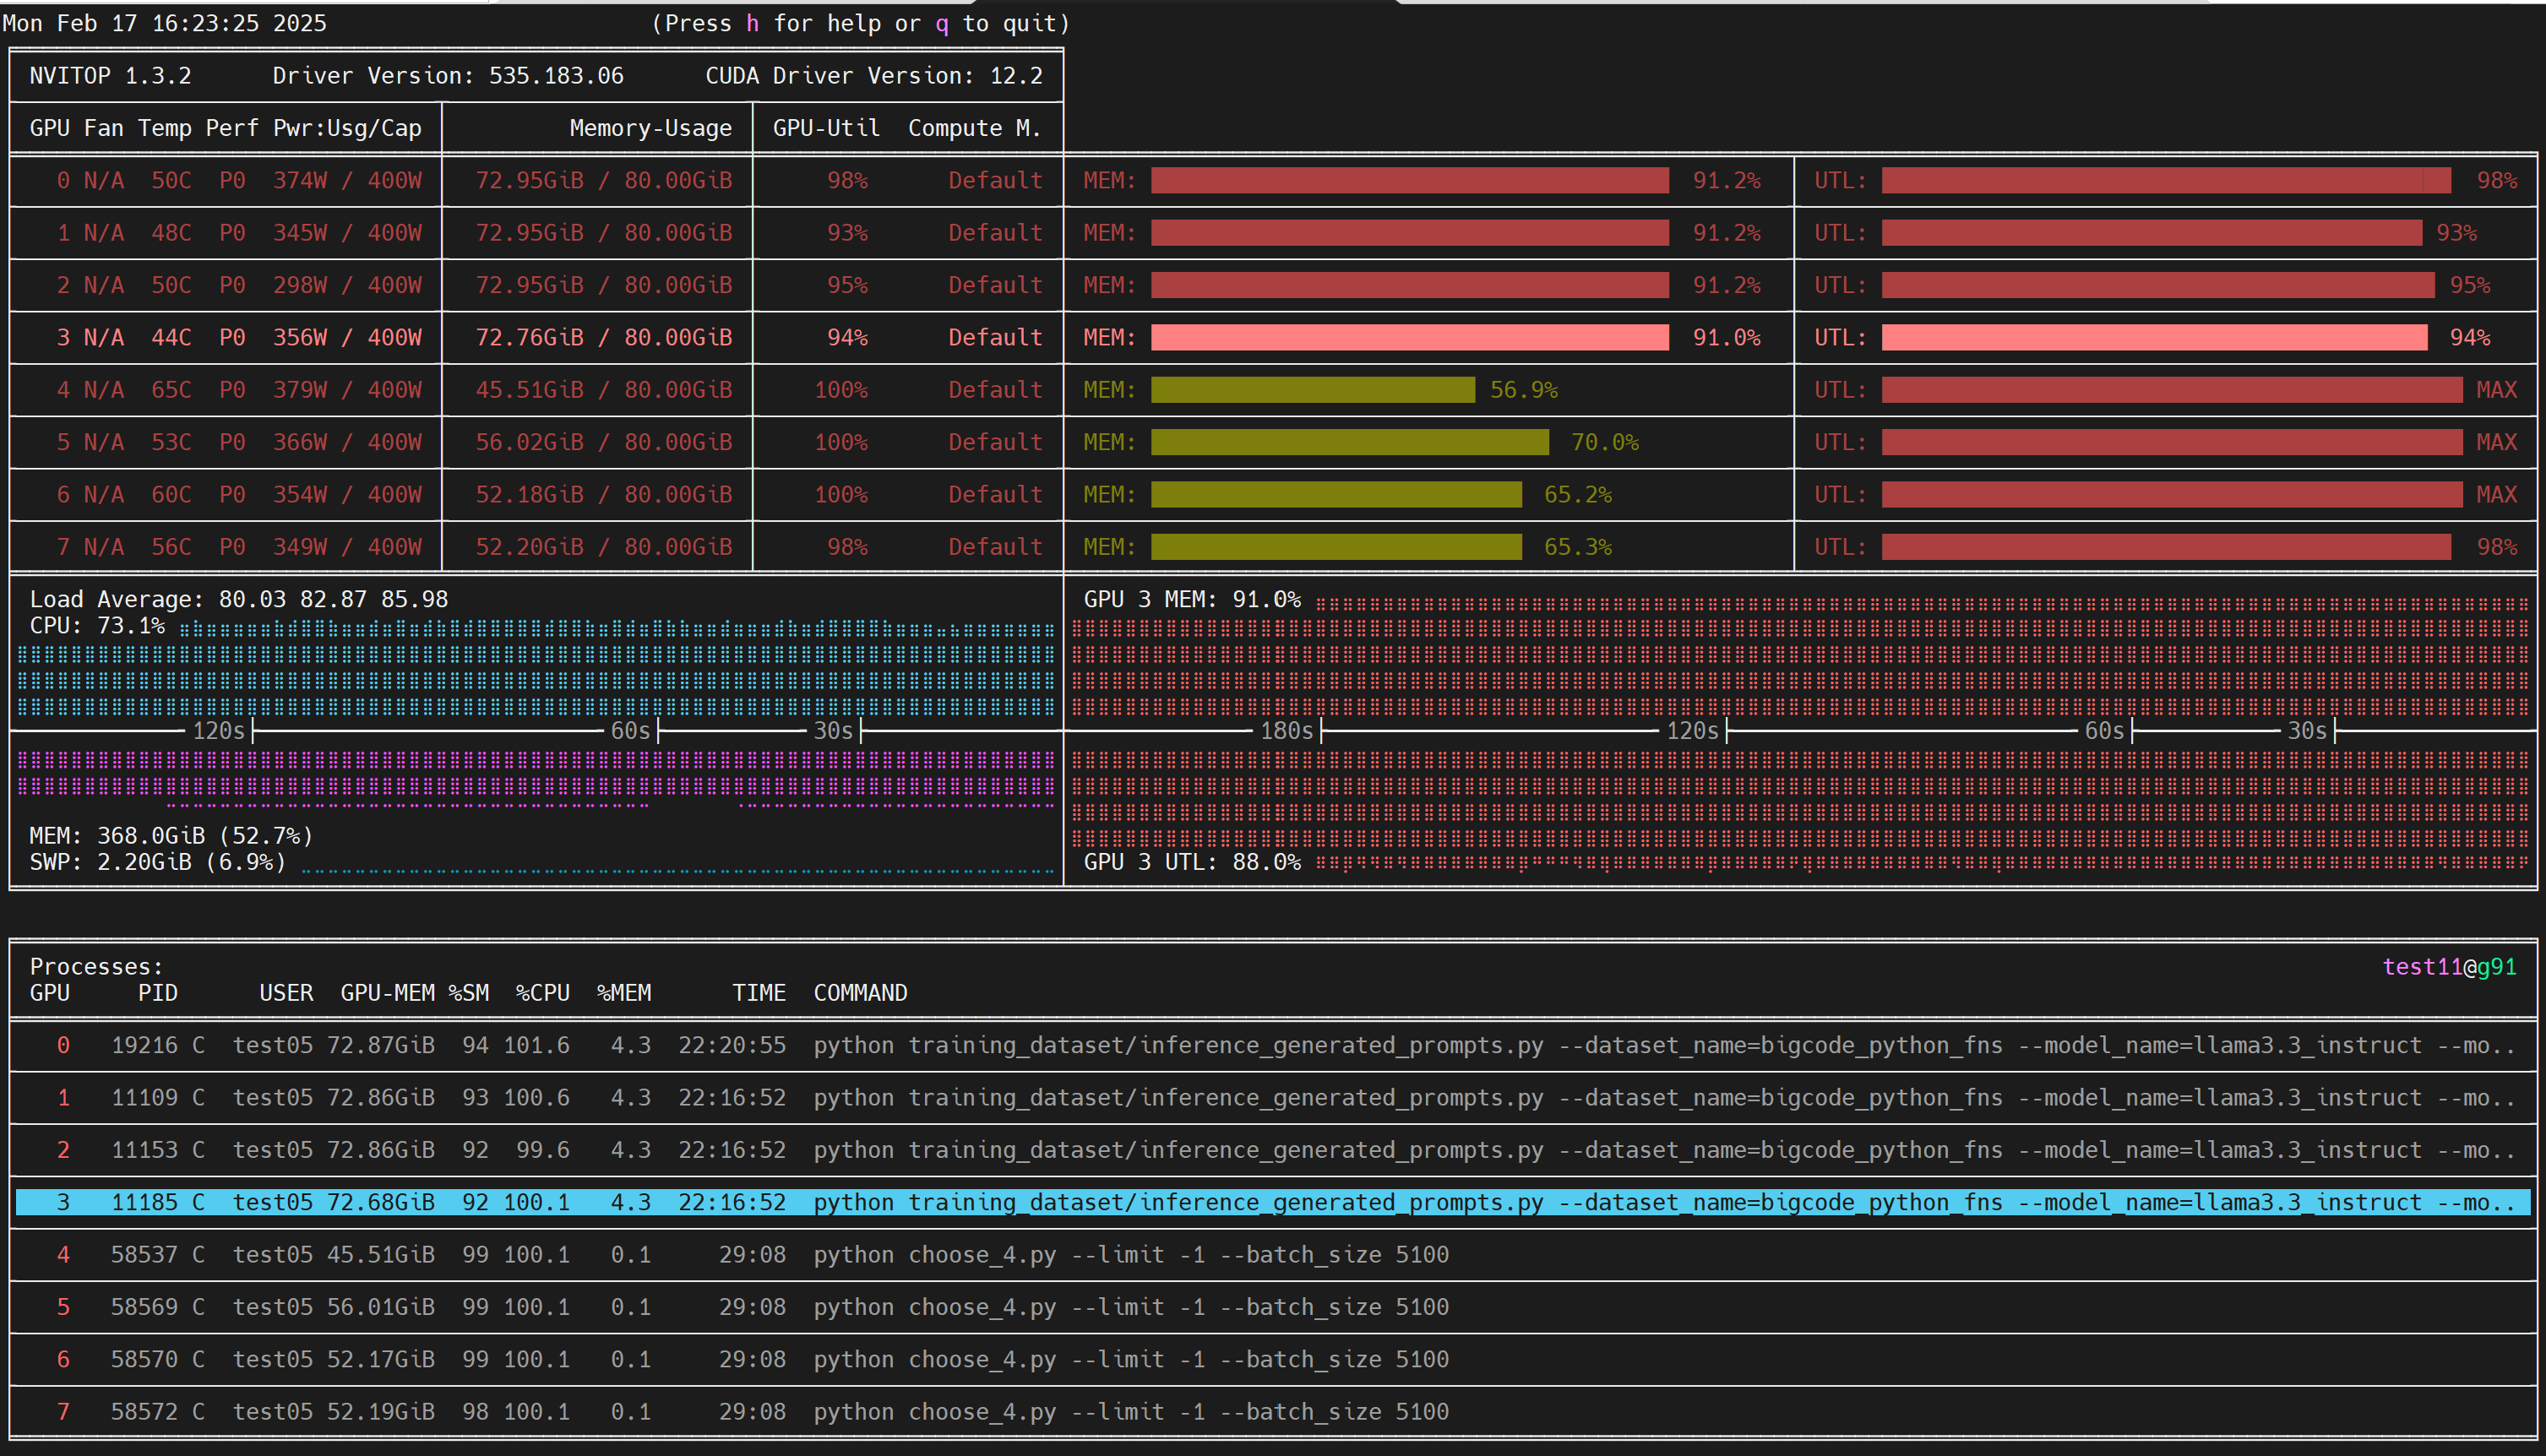

In [23]:
# 使用全局变量 table 来存储数据
table = None
# 这行代码定义了一个全局变量 table，并将其初始值设为 None。
# 在后续的代码中，这个变量可能会被用来存储从图表中提取的数据表格，比如在调用 chart_agent 函数时，如果大语言模型生成了数据表格，就可以将其存储在 table 中。

# 将要处理的图像转换成base64格式
# image_b64 = image2b64("./economic-assistance-chart.png")
image_b64 = image2b64("./test01.png")
#image2b64 是一个自定义函数，它接受一个图像文件路径作为参数，将该图像文件以二进制模式读取，然后使用 base64 编码将其转换为字符串。
# 这里调用该函数，传入的图像文件路径是 ./economic-assistance-chart.png，表示当前目录下名为 economic-assistance-chart.png 的图像文件。
# 转换后的 Base64 编码字符串被赋值给变量 image_b64，这个变量可以作为输入传递给需要处理图像的大语言模型，例如在 chart_agent 函数中，会将其作为图像数据的表示形式传递给视觉大语言模型。

#展示读取的图片
from PIL import Image

display(Image.open("./test01.png"))

# 导入模块：from PIL import Image 从 Python Imaging Library（PIL）的 Pillow 分支中导入 Image 类。
# Pillow 是一个强大的图像处理库，用于打开、操作和保存多种图像文件格式。
# 打开图像：Image.open("./economic-assistance-chart.png") 使用 Image 类的 open 方法打开指定路径的图像文件，返回一个 Image 对象。
# 显示图像：display() 是 Jupyter Notebook 或 IPython 环境中用于显示对象的函数，这里将打开的 Image 对象传递给 display 函数，从而在 Notebook 中显示该图像，方便用户直观地查看要处理的图像内容。
# 综上所述，这段代码主要完成了初始化存储表格数据的全局变量、将图像转换为 Base64 编码以便后续处理，以及在 Notebook 环境中显示图像的功能。

### 执行上面构建好的智能体

#### 先将图片的数据转为字符串

In [24]:
user_input = "show this table in string"
chart_agent(image_b64, user_input, table)
print(table)    # let's see what 'table' looks like now


| GPU Fan Temp Perf | Pwr:Usage/Cap | Memory-Usage | GPU-Util | Compute M. |
|-------------------|---------------|--------------|----------|------------|
| 0 N/A 50C P0      | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      | Default    |
| 1 N/A 48C P0      | 345W / 400W   | 72.95G1B / 80.00G1B | 93%      | Default    |
| 2 N/A 50C P0      | 298W / 400W   | 72.95G1B / 80.00G1B | 95%      | Default    |
| 3 N/A 44C P0      | 356W / 400W   | 72.76G1B / 80.00G1B | 94%      | Default    |
| 4 N/A 65C P0      | 379W / 400W   | 45.51G1B / 80.00G1B | 100%     | Default    |
| 5 N/A 53C P0      | 366W / 400W   | 56.02G1B / 80.00G1B | 100%     | Default    |
| 6 N/A 60C P0      | 354W / 400W   | 52.18G1B / 80.00G1B | 100%     | Default    |
| 7 N/A 56C P0      | 349W / 400W   | 52.20G1B / 80.00G1B | 98%      | Default    |



#### 让 Agent 自己尝试修改其中的内容

比如我们这里要把所有的UK 替换成United Kingdom

In [25]:
user_input = "replace table string's 'Default' with '    ',replace table string's 'Compute M.' with '    '"
# user_input = "replace table string's 'Netherlands' with 'Holland'"
chart_agent(image_b64, user_input, table)
print(table)    # let's see what 'table' looks like now

| GPU Fan Temp Perf | Pwr:Usage/Cap | Memory-Usage | GPU-Util |  |
|-------------------|---------------|--------------|----------|------------|
| 0 N/A 50C P0      | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      |     |
| 1 N/A 48C P0      | 345W / 400W   | 72.95G1B / 80.00G1B | 93%      |     |
| 2 N/A 50C P0      | 298W / 400W   | 72.95G1B / 80.00G1B | 95%      |     |
| 3 N/A 44C P0      | 356W / 400W   | 72.76G1B / 80.00G1B | 94%      |     |
| 4 N/A 65C P0      | 379W / 400W   | 45.51G1B / 80.00G1B | 100%     |     |
| 5 N/A 53C P0      | 366W / 400W   | 56.02G1B / 80.00G1B | 100%     |     |
| 6 N/A 60C P0      | 354W / 400W   | 52.18G1B / 80.00G1B | 100%     |     |
| 7 N/A 56C P0      | 349W / 400W   | 52.20G1B / 80.00G1B | 98%      |     |


| GPU Fan Temp Perf | Pwr:Usage/Cap | Memory-Usage | GPU-Util |       |
|-------------------|---------------|--------------|----------|-------|
| 0 N/A 50C P0      | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      |       |
| 1 N/A 48C P0 

In [26]:
#user_input = "replace table string's 'N/A' with '   |   ',replace table string's 'Fan' with '  |  ' "
#chart_agent(image_b64, user_input, table)
#print(table)    # let's see what 'table' looks like now

user_input = "replace table string's 'Perf' with '    ',replace table string's 'P0' with '    ' "
chart_agent(image_b64, user_input, table)
print(table)    # let's see what 'table' looks like now


| GPU Fan Temp     | Pwr:Usage/Cap | Memory-Usage | GPU-Util |       |
|-------------------|---------------|--------------|----------|-------|
| 0 N/A 50C        | 374W / 400W   | 72.95G1B / 80.00G1B | 98%      |       |
| 1 N/A 48C        | 345W / 400W   | 72.95G1B / 80.00G1B | 93%      |       |
| 2 N/A 50C        | 298W / 400W   | 72.95G1B / 80.00G1B | 95%      |       |
| 3 N/A 44C        | 356W / 400W   | 72.76G1B / 80.00G1B | 94%      |       |
| 4 N/A 65C        | 379W / 400W   | 45.51G1B / 80.00G1B | 100%     |       |
| 5 N/A 53C        | 366W / 400W   | 56.02G1B / 80.00G1B | 100%     |       |
| 6 N/A 60C        | 354W / 400W   | 52.18G1B / 80.00G1B | 100%     |       |
| 7 N/A 56C        | 349W / 400W   | 52.20G1B / 80.00G1B | 98%      |       |




#### 用 python 绘制图表

这里会让大模型生成绘制图像的代码, 并执行生成的代码

In [27]:
user_input = "draw this table as stacked bar chart in python"
result = chart_agent(image_b64, user_input, table)
print("result: "+result)  # let's see what 'table' looks like now

result: However, I don't see a table provided. Could you please provide the table you'd like to draw as a stacked bar chart in Python? Please format it according to the rules you specified, starting with 'TABLE' and ending with 'END_TABLE'. I'll be happy to assist you then!


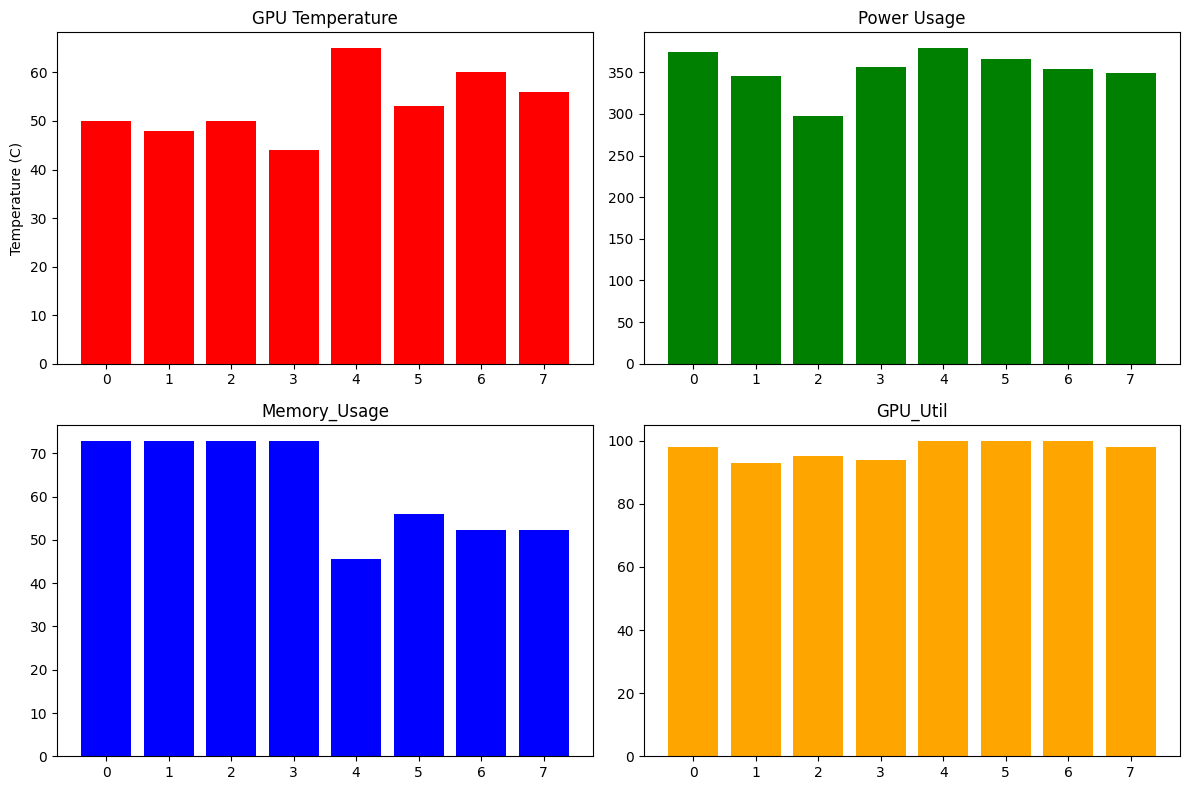

In [28]:
# 下面是根据上面Python代码，修改完善。
# 我们完成了用大模型分析系统运维图片，提取为txt 表格，大模型生成python代码帮助绘图分析 AI Agent
import matplotlib.pyplot as plt
import numpy as np

# Data
GPU_Temp = [50, 48, 50, 44, 65, 53, 60, 56]
Pwr_Usage = [374, 345, 298, 356, 379, 366, 354, 349]
Pwr_Cap = [400, 400, 400, 400, 400, 400, 400, 400]
Memory_Usage = [72.95, 72.95, 72.95, 72.76, 45.51, 56.02, 52.18, 52.20]
Memory_Cap = [80, 80, 80, 80, 80, 80, 80, 80]
GPU_Util = [98, 93, 95, 94, 100, 100, 100, 98]

# 定义 4 种不同的颜色
colors = ['red', 'green', 'blue', 'orange']

# Create the figure and axis
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: GPU Temperature
ax[0, 0].bar(range(len(GPU_Temp)), GPU_Temp, color=colors[0])
ax[0, 0].set_title('GPU Temperature')
#ax[0, 0].set_xlabel('GPU')
ax[0, 0].set_ylabel('Temperature (C)')

# Plot 2: Power Usage
ax[0, 1].bar(range(len(Pwr_Usage)), Pwr_Usage, label='Usage', color=colors[1])
#ax[0, 1].bar(range(len(Pwr_Cap)), Pwr_Cap, label='Capacity')
ax[0, 1].set_title('Power Usage')

# Plot 3: Memory Usage
ax[1, 0].bar(range(len(Memory_Usage)), Memory_Usage, label='Memory_Usage', color=colors[2])
#ax[1, 0].bar(range(len(Memory_Cap)), Memory_Cap, label='Memory_Capacity')
ax[1, 0].set_title('Memory_Usage')

# Plot 4: GPU_Util
ax[1, 1].bar(range(len(GPU_Util)), GPU_Util, label='GPU_Util', color=colors[3])
ax[1, 1].set_title('GPU_Util')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()

# 这个nvitop命令截图，经过我们的RAG LLM AI Agent代码分析为txt ，总结表格，大模型生成python代码，
# 绘图下面图片展示8张GPU卡的 温度、功率、显存使用率、GPU卡核心利用率情况：

## 第四步, 将多模态智能体封装进Gradio

当我们完成上述任务的时候, 就拥有了一个可以分析图片, 生成代码, 修改数据, 执行代码的智能体

接下来我们给这个智能体添加一个UI界面, 让我们可以更舒服的与之对话

我们修改一下执行代码的函数, 因为原生的Python中exec函数的返回是Nan, 所以我们给他添加一个生成图片的路径

在下面的代码中, 路径是作者的PC中的路径, 请您根据您自己的系统更换这个文件夹路径

In [43]:
global img_path
img_path = './'+'image.png'
print(img_path)


# global 关键字用于在函数内部声明一个变量为全局变量。在 Python 中，当你在函数内部想要修改全局变量的值时，需要使用 global 关键字进行声明，否则 Python 会将其视为一个局部变量。不过在这段代码中，它并非处于函数内部，所以这里使用 global 关键字并没有实际的必要，只是表明后续定义的 img_path 是一个全局变量。
# 对 img_path 变量的赋值操作。通过字符串拼接的方式，将当前目录的相对路径 './' 和文件名 'image.png' 连接起来，得到一个完整的文件路径字符串。最终 img_path 的值为 './image.png'，表示当前目录下的 image.png 文件。
# 调用 Python 的内置函数 print()，将变量 img_path 的值输出到控制台。这有助于在代码调试过程中确认 img_path 是否被正确赋值，或者在程序运行时向用户展示当前所使用的文件路径
# 通过字符串拼接生成一个文件路径，并将其存储在全局变量中，最后将该路径打印输出。

./image.png


In [44]:
def execute_and_return_gr(x):
    code = extract_python_code(x.content)[0]
# extract_python_code 是一个自定义函数，它的作用是从文本中提取被 Markdown 代码块（以 python` 开头，以 结尾）包裹的 Python 代码。
# 这里调用该函数，传入 x.content，即输入对象 x 的 content 属性值，它通常是包含文本信息的字符串。
# [0] 表示从提取到的代码列表中取出第一个元素。这意味着该函数假设输入的 x.content 中只有一个 Python 代码块，并只取这个代码块进行后续处理。
    
    try:
        result = exec(str(code))
        #print("exec result: "+result)
    except ExceptionType:
        print("The code is not executable, don't give up, try again!")
    return img_path
# execute_and_return_gr 函数的主要目的是从输入对象 x 的 content 属性中提取 Python 代码，然后尝试执行该代码，若执行过程中出现异常则给出提示信息，最后返回全局变量 img_path


In [45]:
# chart_agent_gr 函数是一个综合性的智能代理函数，用于处理包含图像和文本输入的任务。
# 它借助视觉大语言模型从图像中提取数据表格，再结合用户输入和已有表格数据，利用指令式大语言模型生成响应，并对响应中的表格和代码进行处理和执行。
def chart_agent_gr(image_b64, user_input, table):

    image_b64 = image2b64(image_b64)
    # Chart reading Runnable
    chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
    chart_reading_prompt = ChatPromptTemplate.from_template(
        'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />'
    )
    chart_chain = chart_reading_prompt | chart_reading
# 模型实例化：使用 ChatNVIDIA 类创建一个视觉大语言模型实例 chart_reading，指定使用 microsoft/phi-3-vision-128k-instruct 模型，该模型具备处理图像数据并生成相关信息的能力。
# 提示模板创建：利用 ChatPromptTemplate.from_template 方法创建一个提示模板 chart_reading_prompt，模板中包含 Base64 编码的图像信息，要求模型根据图像生成其背后的数据表格。
# 链式调用组合：通过 | 操作符将提示模板和模型组合成一个链式调用 chart_chain，意味着先应用提示模板对输入进行格式化，再将处理后的输入传递给模型进行推理。

    # Instruct LLM Runnable
    # instruct_chat = ChatNVIDIA(model="nv-mistralai/mistral-nemo-12b-instruct")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-8b-instruct")
    # instruct_chat = ChatNVIDIA(model="ai-llama3-70b")
    # instruct_chat = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")
    instruct_chat = ChatNVIDIA(model="meta/llama-3.1-70b-instruct")

    instruct_prompt = ChatPromptTemplate.from_template(
        "Do NOT repeat my requirements already stated. Based on this table {table}, {input}" \
        "If has table string, start with 'TABLE', end with 'END_TABLE'." \
        "If has code, start with '```python' and end with '```'." \
        "Do NOT include table inside code, and vice versa."
    )
    instruct_chain = instruct_prompt | instruct_chat
# 模型选择：再次使用 ChatNVIDIA 类创建一个指令式大语言模型实例 instruct_chat，选择 meta/llama-3.1-70b-instruct 模型，该模型用于根据给定的表格数据和用户输入生成相应的回答。
# 提示模板设置：创建提示模板 instruct_prompt，向模型提出一系列要求，如不重复已有需求、规范表格和代码的格式等，以确保生成的回答符合预期。
# 链式调用构建：同样通过 | 操作符将提示模板和模型组合成 instruct_chain，实现按顺序处理输入
    

    # 根据“表格”决定是否读取图表
    chart_reading_branch = RunnableBranch(
        (lambda x: x.get('table') is None, RunnableAssign({'table': chart_chain })),
        (lambda x: x.get('table') is not None, lambda x: x),
        lambda x: x
    )
# RunnableBranch 是一个用于实现分支逻辑的工具。
# 第一个分支：当输入数据中的 table 字段为 None 时，使用 RunnableAssign 将 chart_chain 的输出赋值给 table 字段，即调用视觉模型读取图像生成表格数据。
# 第二个分支：若 table 字段不为 None，则直接返回输入数据，不进行图表读取操作。
# 最后一个 lambda x: x 是默认分支，保证无论何种情况都有输出
    
    # 根据需求更新table
    update_table = RunnableBranch(
        (lambda x: 'TABLE' in x.content, save_table_to_global),
        lambda x: x
    )
# 当 x.content 中包含 TABLE 字符串时，说明模型生成的回答中包含表格数据，调用 save_table_to_global 函数将表格数据保存到全局变量中。
# 否则，直接返回输入数据。
    
    execute_code = RunnableBranch(
        (lambda x: '```python' in x.content, execute_and_return_gr),
        lambda x: x
    )
# 若 x.content 中包含 ````python字符串，表明模型生成的回答中包含 Python 代码，调用execute_and_return_gr` 函数执行代码。
# 若不包含，则直接返回输入数据。
    
    # 执行绘制图表的代码
    chain = (
        chart_reading_branch
        #| RunnableLambda(print_and_return)
        | instruct_chain
        #| RunnableLambda(print_and_return)
        | update_table
        | execute_code
    )
# 整体链式调用及结果返回
# 将前面定义的各个分支和链式调用组合成一个完整的处理链 chain。
# 使用 chain.invoke 方法传入包含图像 Base64 编码、用户输入和表格数据的字典进行调用，并返回处理结果。
    
    return chain.invoke({"image_b64": image_b64, "input": user_input, "table": table})

这里是示意提示词, 方便大家打开Gradio页面时候直接复制粘贴

In [46]:
#user_input = "replace table string's 'Netherlands' with 'Holland'', draw this table as stacked bar chart in python, and save the image in path: "+img_path
#print(user_input)

#user_input = "replace table string's 'Netherlands' with 'Holland'', draw this table as stacked bar chart in python, and save the image in path: "+img_path
#print(user_input)


In [ ]:
#user_input = "replace table string's 'Netherlands' with 'Holland'', draw this table as stacked bar chart in python, and save the image in path: ./image.png"
#user_input = "replace table string's 'P0' with '   ', replace table string's 'Fan' with '   ',replace table string's 'Perf' with '   ',draw this table as stacked bar chart in python, and save the image in path: ./image.png"

#user_input = "replace table string's 'Default' with '    ',replace table string's 'Compute M.' with '    '"
#user_input = "replace table string's 'N/A' with '   |   ',replace table string's 'Fan' with '  |  ' "
#user_input = "replace table string's 'Perf' with '    ',replace table string's 'P0' with '    ' "
#user_input = "draw this table as stacked bar chart in python"
# , and save the image in path: ./image.png

user_inputs = "replace table string's 'Default' with '    ',replace table string's 'Compute M.' with '    ',replace table string's 'N/A' with '   |   ',replace table string's 'Fan' with '  |  ',replace table string's 'Perf' with '    ',replace table string's 'P0' with '    ',draw this table as stacked bar chart in python, and save the image in path: ./image.png"

print(user_inputs)
# replace table string's 'Default' with '    ',replace table string's 'Compute M.' with '    ',replace table string's 'N/A' with '   |   ',replace table string's 'Fan' with '  |  ',replace table string's 'Perf' with '    ',replace table string's 'P0' with '    ',draw this table as stacked bar chart in python, and save the image in path: ./image.png

result = chart_agent(image_b64, user_inputs, table)
print("result: "+result)  # let's see what 'table' looks like now

执行下面代码, 将打开一个Gradio的服务, 我们可以利用Gradio的页面与构建好的智能体对话

注意: 以下代码是打开gradio的后端服务，前端页面的展示是需要新开一个浏览器窗口通过输入ip地址：http://36.150.110.74 和对应的端口号如：9597 即 http://36.150.110.74:9597/ 进行前端演示
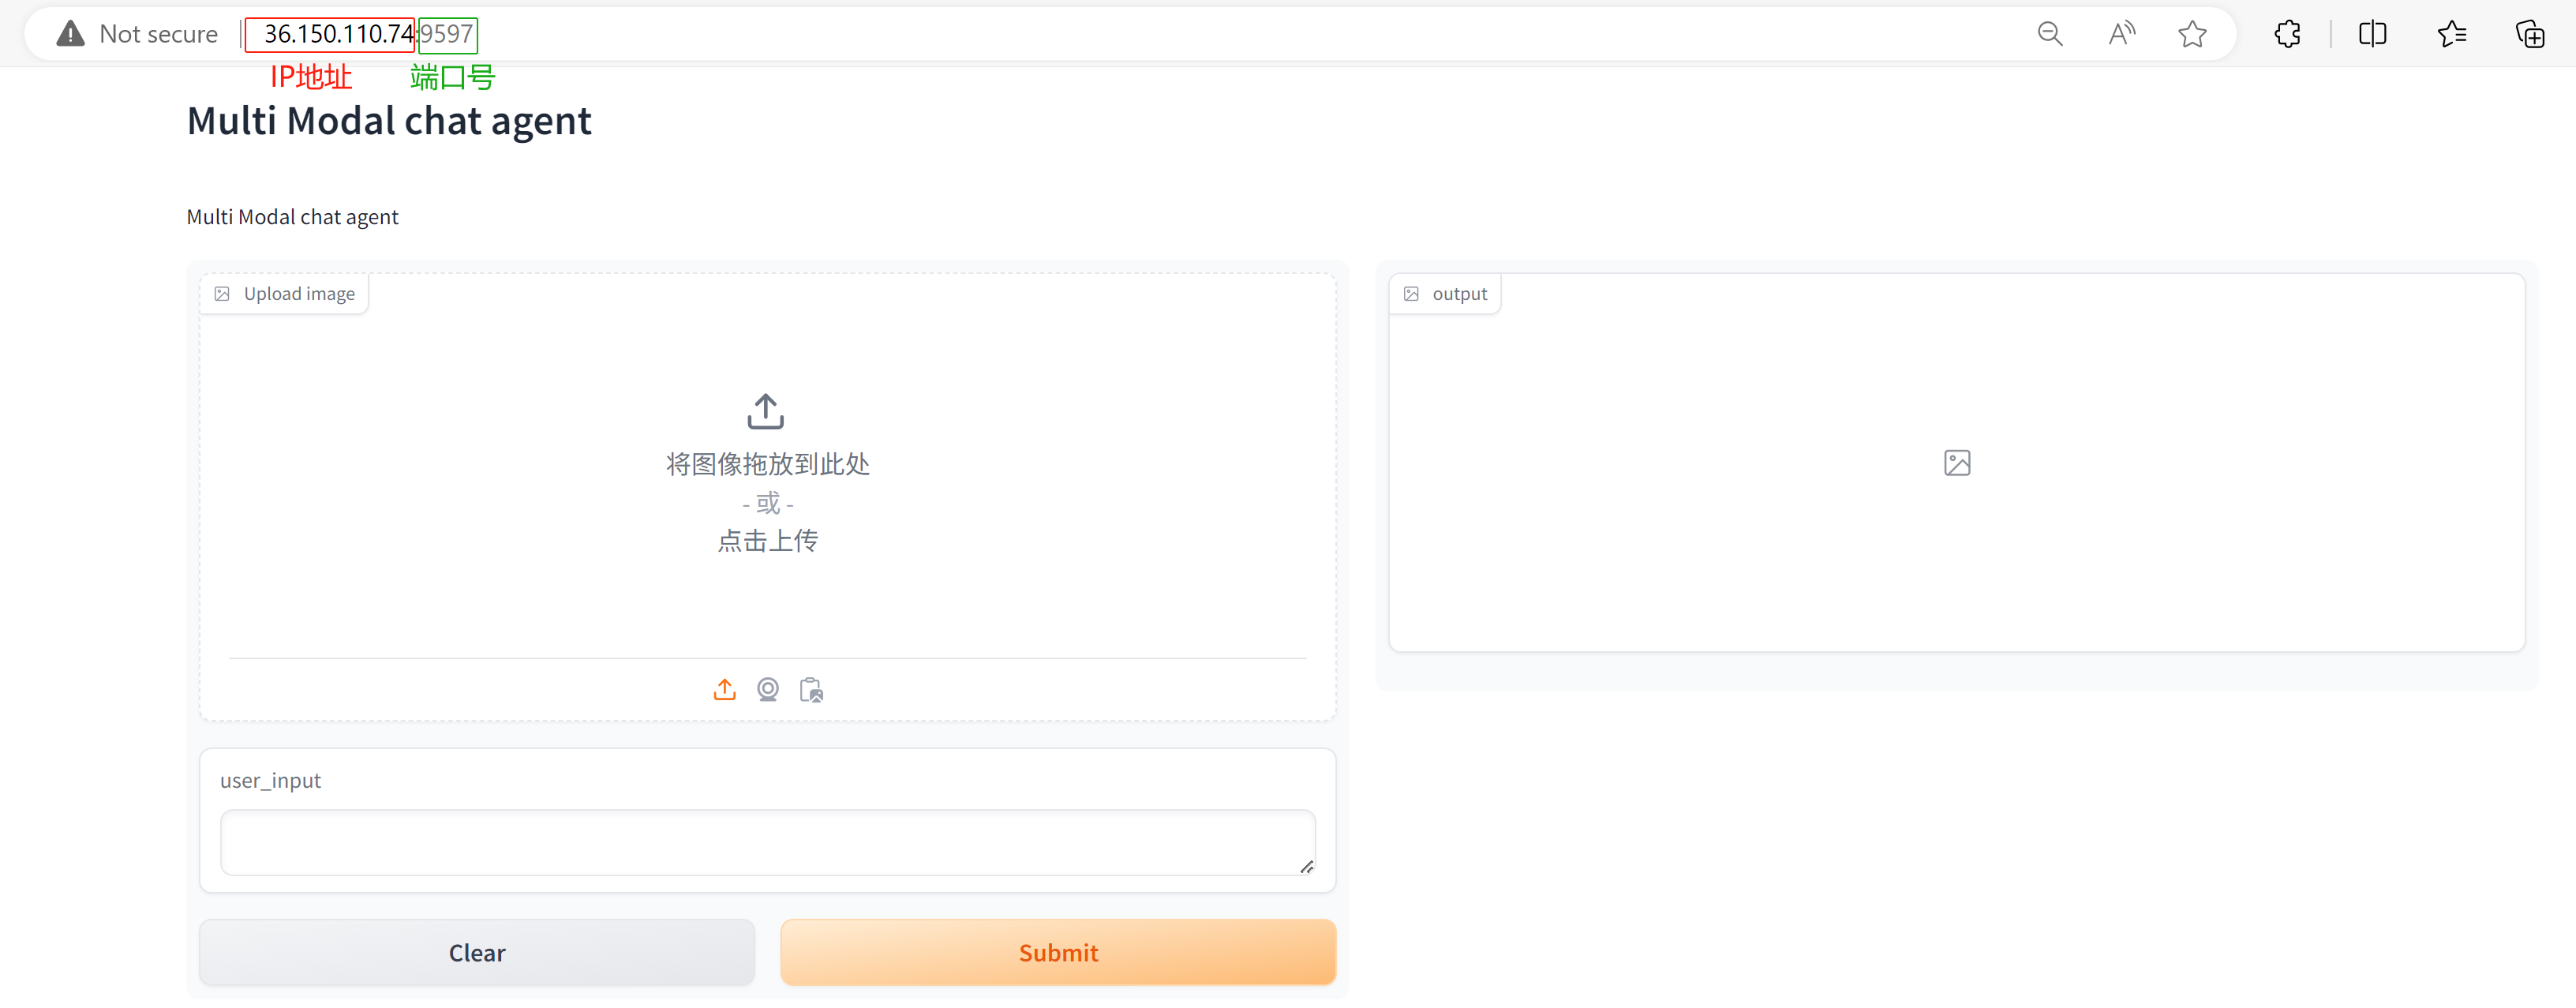
![本地图片](./images/picture.png "图片标题")


举例：如果您在Jetson节点中的端口号是9910，那么前端所对应的ip及端口就是：http://36.150.110.74:9510/

In [ ]:
import gradio as gr
# 这行代码导入了 Gradio 库，并将其重命名为 gr。Gradio 是一个用于快速创建自定义机器学习演示界面的 Python 库，
# 它允许开发者通过简单的代码构建交互式的 Web 界面，方便用户与机器学习模型或函数进行交互。
from tqdm import tqdm

multi_modal_chart_agent = gr.Interface(fn=chart_agent_gr,
                    inputs=[gr.Image(label="Upload image", type="filepath"), 'text'],
                    outputs=['image'],
                    title="Multi Modal chat agent",
                    description="Multi Modal chat agent",
                    allow_flagging="never")
# gr.Interface 类：这是 Gradio 库中用于创建界面的核心类。
# fn=chart_agent_gr：指定了界面要调用的函数为 chart_agent_gr。当用户在界面上输入数据并提交时，Gradio 会将用户输入传递给 chart_agent_gr 函数进行处理，并将函数的返回值作为输出显示在界面上。
# inputs=[gr.Image(label="Upload image", type="filepath"), 'text']：定义了界面的输入组件。
# gr.Image(label="Upload image", type="filepath")：创建一个图像上传组件，用户可以通过该组件上传图像文件。label="Upload image" 为该组件设置了标签，显示在界面上提示用户操作；type="filepath" 表示该组件将返回上传图像文件的本地文件路径。
# 'text'：创建一个文本输入框，用户可以在其中输入文本信息。
# outputs=['image']：定义了界面的输出组件。这里指定输出为一个图像，意味着 chart_agent_gr 函数的返回值应该是一个可以被 Gradio 识别为图像的数据，例如图像文件路径或图像数组。
# title="Multi Modal chat agent"：为界面设置标题，显示在界面的顶部。
# description="Multi Modal chat agent"：为界面设置描述信息，通常显示在标题下方，用于简要说明界面的功能。
# allow_flagging="never"：设置是否允许用户标记输出。"never" 表示不允许用户标记输出，即用户无法对界面的输出进行标记或反馈。


multi_modal_chart_agent.launch(debug=True, share=False, show_api=False, server_port=5000, server_name="0.0.0.0")
#multi_modal_chart_agent.launch(debug=True, share=False, show_api=False, server_port=8898, server_name="0.0.0.0")
# launch 方法：用于启动 Gradio 界面并将其部署为一个本地 Web 服务器。
# debug=True：启用调试模式。在调试模式下，如果代码中出现错误，Gradio 会在界面上显示详细的错误信息，方便开发者进行调试。
# share=False：设置是否生成一个公共的共享链接。False 表示不生成共享链接，界面只能在本地访问；如果设置为 True，Gradio 会生成一个公共的共享链接，其他用户可以通过该链接访问界面。
# show_api=False：设置是否显示 API 文档。False 表示不显示 API 文档，即不在界面上提供关于接口 API 的详细信息。
# server_port=5000：指定服务器监听的端口号为 5000。用户可以通过访问 http://localhost:5000 来打开界面。
# server_name="0.0.0.0"：指定服务器监听的 IP 地址为 0.0.0.0，表示服务器将监听所有可用的网络接口，这样不仅可以在本地访问界面，还可以在同一局域网内的其他设备上访问。
# 注释掉的那行代码是另一种启动方式，只是将端口号改为了 8898。
# 综上所述，这段代码创建了一个具有图像上传和文本输入功能的交互式界面，用户可以通过该界面上传图像并输入文本，界面会调用 chart_agent_gr 函数进行处理，并将处理结果以图像形式显示出来。

### 最终结果前端展示
![image.png](./table.png)
![image.png](./gradio.png)

# 功能2：解析pdf文档

In [62]:
# 提取pdf文件中的内容,保存为本地目录下RoCE.txt
#import fitz  # PyMuPDF
#import base64
#from langchain_nvidia_ai_endpoints import ChatNVIDIA
#
#def invoke_model_with_image(image_b64, model_instance):
#    """向模型发送包含Base64编码图像的查询"""
#    query = f'Generate underlying data table of the figure below: <img src="data:image/png;base64,{image_b64}" />'
#    response = model_instance.invoke({"input": query})
#    return response

#def extract_text_from_pdf(pdf_path):
#    """从给定路径的PDF文件中提取文本"""
#    document = fitz.open(pdf_path)  # 打开PDF文件
#    text = ""
#    for page_num in range(len(document)):
#        page = document.load_page(page_num)
#        text += page.get_text()
#    return text

## PDF文件路径
#pdf_file_path = './RoCE.pdf'

## 提取PDF中的文本内容
#pdf_text = extract_text_from_pdf(pdf_file_path)
#print("Extracted Text from PDF:")
#print(pdf_text)

In [63]:
# 提取pdf文件中的内容,保存为本地目录下RoCE.txt
import fitz  # PyMuPDF

def extract_text_from_pdf(pdf_path):
    """从给定路径的PDF文件中提取文本"""
    document = fitz.open(pdf_path)  # 打开PDF文件
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

def save_text_to_file(text, file_path="RoCE.txt"):
    """将提取的文本保存到指定文件"""
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Text saved to {file_path}")

# PDF文件路径
pdf_file_path = './RoCE.pdf'

# 提取PDF中的文本内容
pdf_text = extract_text_from_pdf(pdf_file_path)

# 打印提取的文本（可选）
print("Extracted Text from PDF:")
print(pdf_text)

# 将提取的文本保存到本地文件
save_text_to_file(pdf_text)

Extracted Text from PDF:
 
 
 
 
 
 
 
ROCE 以太网交换机网络配置实践 
 
 
 
                                          
                                          
目 录 
1 原理描述 ...................................................................................................................................... 1 
1.1 基本概念 ................................................................................................................................... 1 
1.2 应用场景 ................................................................................................................................... 2 
2 方案描述 ...................................................................................................................................... 4 
2.1 AI 大模型训练网络场景 ......................................................................................................... 4 
2.2 组网方案 ................................................................................................................................... 

## 提取pdf当中所有图像

** 提取的图像可以借用上面的用图像分析内容

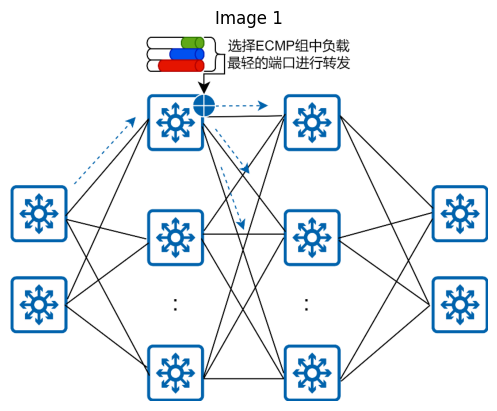

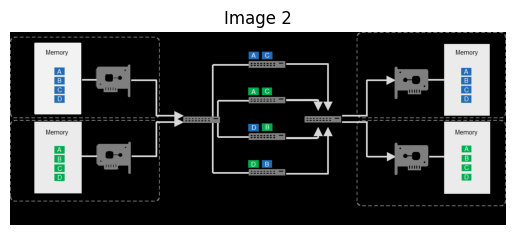

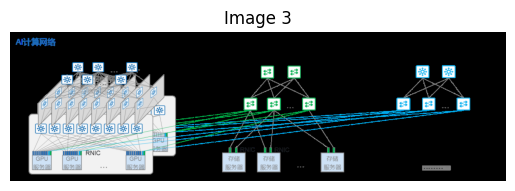

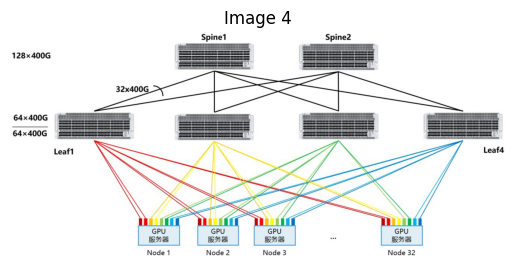

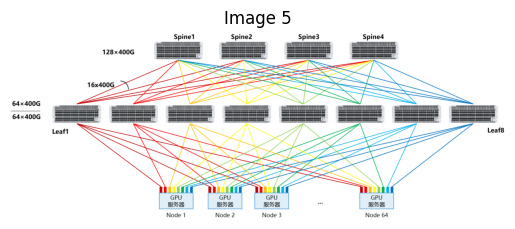

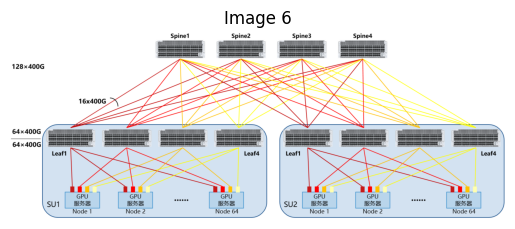

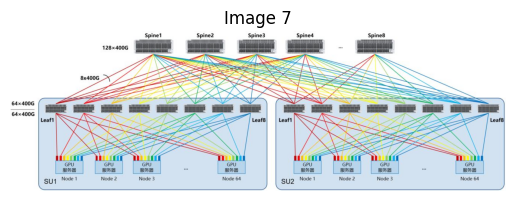

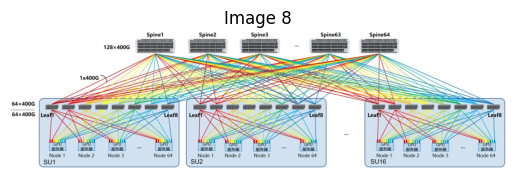

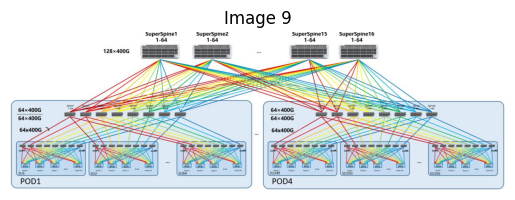

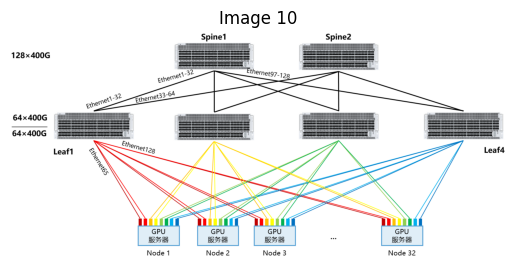

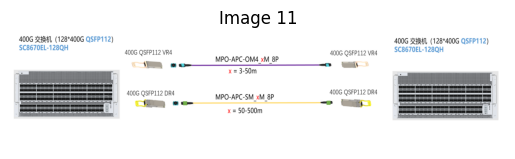

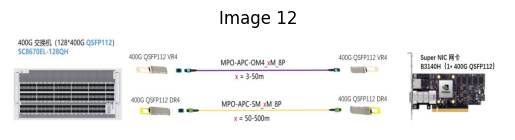

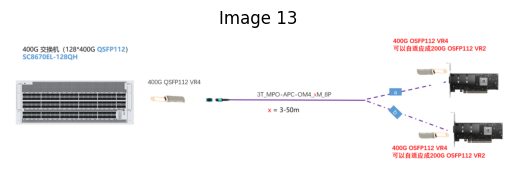

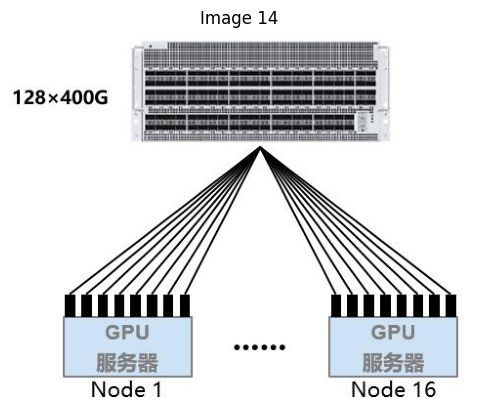

In [64]:
import fitz  # PyMuPDF
import base64
from PIL import Image
import io
import matplotlib.pyplot as plt

# 提取PDF中的所有图像
def extract_images_from_pdf(pdf_path):
    """从给定路径的PDF文件中提取所有图像"""
    document = fitz.open(pdf_path)  # 打开PDF文件
    images = []
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        image_list = page.get_images(full=True)
        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = document.extract_image(xref)
            image_data = base_image["image"]
            # 将二进制图像数据转换为PIL图像对象
            image = Image.open(io.BytesIO(image_data))
            images.append(image)
    return images

def display_images(images):
    """显示提取的图像"""
    for idx, image in enumerate(images):
        plt.figure()
        plt.imshow(image)
        plt.title(f"Image {idx + 1}")
        plt.axis('off')  # 不显示坐标轴
        plt.show()

# PDF文件路径
pdf_file_path = './RoCE.pdf'

# 提取PDF中的所有图像
images = extract_images_from_pdf(pdf_file_path)

# 显示每个图像
display_images(images)

In [65]:
import fitz  # PyMuPDF
import os
from PIL import Image
import io

def extract_images_from_pdf(pdf_path):
    """从给定路径的PDF文件中提取所有图像"""
    document = fitz.open(pdf_path)  # 打开PDF文件
    images = []
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        image_list = page.get_images(full=True)
        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = document.extract_image(xref)
            image_data = base_image["image"]
            # 将二进制图像数据转换为PIL图像对象
            image = Image.open(io.BytesIO(image_data))
            images.append(image)
    return images

def save_images_to_folder(images, folder_path="RoCEimage"):
    """将提取的图像保存到指定文件夹"""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for idx, image in enumerate(images):
        file_name = f"roce{idx + 1:02d}.png"
        file_path = os.path.join(folder_path, file_name)
        image.save(file_path, format="PNG")
        print(f"Saved {file_path}")

# PDF文件路径
pdf_file_path = './RoCE.pdf'

# 提取PDF中的所有图像
images = extract_images_from_pdf(pdf_file_path)

# 保存每个图像到指定文件夹
save_images_to_folder(images)

Saved RoCEimage\roce01.png
Saved RoCEimage\roce02.png
Saved RoCEimage\roce03.png
Saved RoCEimage\roce04.png
Saved RoCEimage\roce05.png
Saved RoCEimage\roce06.png
Saved RoCEimage\roce07.png
Saved RoCEimage\roce08.png
Saved RoCEimage\roce09.png
Saved RoCEimage\roce10.png
Saved RoCEimage\roce11.png
Saved RoCEimage\roce12.png
Saved RoCEimage\roce13.png
Saved RoCEimage\roce14.png


- 代码说明
- 提取图像:
使用 fitz.open() 打开PDF文件。
遍历每一页，并使用 get_images(full=True) 获取页面上的所有图像。
对于每个图像，使用 extract_image(xref) 提取图像数据，并将其转换为 PIL.Image 对象。
- 保存图像:
save_images_to_folder 函数首先检查目标文件夹是否存在，如果不存在则创建它。
然后遍历提取出的所有图像，使用 Image.save() 方法将它们以 PNG 格式保存到指定的文件夹中。文件名按照 roce01.png, roce02.png 这样的格式命名。

## 复用前面代码实现RAG检索流程

In [66]:
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

import os                  #导入os模块，该模块提供了与操作系统进行交互的功能，比如文件和目录操作。
from tqdm import tqdm      #导入tqdm库中的tqdm函数，tqdm可以在循环中显示进度条，让用户直观地了解循环的执行进度。
from pathlib import Path   #导入pathlib模块中的Path类，Path类提供了一种面向对象的方式来处理文件系统路径。

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("./")    #使用os.listdir()函数获取当前目录（.表示当前目录）下的所有文件和文件夹的名称，并将这些名称存储在列表ps中
data = []     # 创建一个空列表data，用于存储从文本文件中读取的所有有效行。
sources = []  # 创建一个空列表sources，用于存储每一行数据对应的文件路径。
for p in ps:  # 遍历列表ps中的每个文件或文件夹名称
    if p.endswith('.txt'):  # 检查当前文件或文件夹名称是否以.txt结尾，如果是，则表示这是一个文本文件，需要进行处理。
        path2file="./"+p    # 构建当前文本文件的完整路径，将当前目录（./）和文件名拼接起来。
        with open(path2file,encoding="utf-8") as f:  # 使用open()函数以 UTF - 8 编码打开当前文本文件，并将文件对象赋值给变量f。with语句会在文件使用完毕后自动关闭文件。
            lines=f.readlines()  # 使用readlines()方法读取文件中的所有行，并将这些行存储在列表lines中。 
            for line in lines:   # 遍历列表lines中的每一行。
                if len(line)>=1:  # 检查当前行的长度是否大于等于 1，如果是，则表示这是一个有效行。
                    data.append(line)  # 将有效行添加到列表data中。
                    sources.append(path2file)  # 将当前行对应的文件路径添加到列表sources中。

In [67]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0],data[-1]
# 这行代码实际上是一个元组，它分别计算了列表 data 的长度、列表 documents 的长度，并且获取了列表 data 的第一个元素,data 的最后一个元素。
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings #langchain_nvidia_ai_endpoints 是一个自定义的 Python 模块，可能是由 NVIDIA 相关团队开发并集成到 langchain 生态系统中的。langchain 是一个用于开发由语言模型驱动的应用程序的框架，支持各种语言模型和工具的集成。NVIDIAEmbeddings 是从 langchain_nvidia_ai_endpoints 模块中导入的一个类。这个类通常用于将文本数据转换为向量表示，也就是文本嵌入（embeddings）。文本嵌入是将文本转换为数值向量的过程，这些向量可以用于各种自然语言处理任务，如文本相似度计算、信息检索、聚类等。

#embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")
embedder = NVIDIAEmbeddings(model="NV-Embed-QA")  
#是传递给 NVIDIAEmbeddings 类构造函数的一个参数，它指定了要使用的嵌入模型。NV-Embed-QA 是 NVIDIA 提供的一个专门用于问答任务（QA，Question - Answering）的嵌入模型。当你调用 embedder 对象的相关方法时，它会使用 NV-Embed-QA 模型将输入的文本转换为对应的向量表示。

In [68]:
# 只需要执行一次，后面可以重读已经保存的向量存储
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
# CharacterTextSplitter 是 langchain 库中用于按字符进行文本分割的工具类。
# chunk_size=400：指定每个分割块的最大字符数为 400。即文本会被分割成字符数不超过 400 的小块。
# separator=" "：指定分割文本时使用的分隔符为空格。当分割文本时，会尽量以空格为界限来划分出不超过 400 字符的块。
docs = []  # docs：用于存储分割后的文本块。
metadatas = []  # metadatas：用于存储每个文本块对应的元数据，这里的元数据主要是文本块的来源信息。

for i, d in enumerate(documents):          # 使用 enumerate 函数遍历 documents 列表，i 是当前文档的索引，d 是当前文档的内容。
    splits = text_splitter.split_text(d)   # 调用 text_splitter 的 split_text 方法，将当前文档 d 分割成多个小块，结果存储在 splits 列表中。
    #print(len(splits))
    docs.extend(splits)    # 将分割后的文本块添加到 docs 列表中。
    metadatas.extend([{"source": sources[i]}] * len(splits))  # 为每个分割后的文本块生成对应的元数据，元数据是一个字典，键为 "source"，值为该文本块原始文档的来源（存储在 sources 列表中）。[{"source": sources[i]}] * len(splits) 会生成与分割后的文本块数量相同的元数据列表，然后将其添加到 metadatas 列表中。

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)   
store.save_local('./nv_embedding')

# FAISS 是一个用于高效相似性搜索和聚类的开源库，这里使用 langchain 对其进行了封装。
# FAISS.from_texts 是一个类方法，用于从文本列表构建 FAISS 向量索引。
# docs：输入的文本列表，即分割后的文本块。
# embedder：之前创建的嵌入器实例，用于将文本转换为向量表示。
# metadatas：每个文本块对应的元数据列表。
# 调用 store 对象的 save_local 方法，将构建好的 FAISS 向量索引保存到本地的 ./nv_embedding 目录下。后续可以从该目录加载索引进行相似性搜索等操作。
# 综上所述，这段代码的整体作用是将原始文本数据进行分割、向量化，并构建向量索引保存到本地，以便后续进行高效的文本搜索和检索。

In [69]:
#llm = ChatNVIDIA(model="ai-llama3-70b")
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

# 这行代码的主要功能是创建一个基于 NVIDIA 相关技术的大语言模型实例 llm，并且指定使用的具体模型为 "meta/llama3-70b-instruct"。该实例可以用于后续的文本生成、问答等自然语言处理任务。
# model="meta/llama3-70b-instruct" 参数
# model：这是传递给 ChatNVIDIA 类构造函数的一个重要参数，用于指定要使用的具体大语言模型。
# "meta/llama3-70b-instruct"：
# "meta" 通常表示该模型由 Meta（原 Facebook）公司开发。Meta 在自然语言处理领域有诸多研究和贡献，开发了许多知名的大语言模型。
# "llama3" 表明使用的是 Llama 系列的第三代模型。Llama 模型以其强大的语言理解和生成能力而受到广泛关注。
# "70b" 代表该模型具有 700 亿个参数。一般来说，模型的参数数量越多，其学习能力和表达能力就越强，能够处理更复杂的语言任务和生成更高质量的文本。
# "instruct" 说明这是一个经过指令微调的模型。经过指令微调的模型能够更好地理解用户以指令形式给出的任务描述，并按照指令生成相应的输出，例如回答问题、完成文本续写、进行文本摘要等。

In [70]:
# 创建检索器
retriever = store.as_retriever()
# store 是之前使用 FAISS.from_texts 方法构建的向量索引对象。
# as_retriever() 是 store 对象的一个方法，它将向量索引转换为一个检索器 retriever。检索器的作用是根据输入的查询文本，在向量索引中查找与之最相似的文本块。

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)
# ChatPromptTemplate 是 langchain 库中用于创建聊天提示模板的类。
# from_messages 是该类的一个类方法，用于从消息列表创建提示模板。消息列表中的每个元素是一个元组，包含消息的角色（如 "system" 或 "user"）和消息内容。
# "system" 消息是系统级别的提示信息，告诉大语言模型回答问题时仅基于提供的上下文信息。{context} 是一个占位符，后续会被检索到的相关文本块填充。
# "user" 消息是用户提出的问题，{question} 是一个占位符，会被实际的问题文本替换。



chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
# 这里使用了 langchain 的链式调用语法，将多个组件组合成一个处理链。
# {"context": retriever, "question": RunnablePassthrough()}：这是一个字典，用于将输入数据进行分发。"context" 键对应的值是 retriever，表示将输入的问题传递给检索器，检索器会返回相关的文本块作为上下文；"question" 键对应的值是 RunnablePassthrough()，表示将输入的问题原样传递下去。
# | prompt：将分发后的数据传递给提示模板 prompt，提示模板会根据占位符 {context} 和 {question} 填充相应的内容，生成完整的提示信息。
# | llm：将填充好的提示信息传递给大语言模型 llm，大语言模型根据提示信息生成答案。
# | StrOutputParser()：将大语言模型生成的输出解析为字符串类型。


#chain.invoke("Malaysia 2023 Growth？")
#chain.invoke("China 2023 Growth？")
#chain.invoke("Indonesia 2023 Growth？")
chain.invoke("ROCE 交换机三层组网最大可支持 多少个GPU卡？")
#chain.invoke("which COMMAND belong test05 ？")
# invoke 是处理链 chain 的一个方法，用于启动整个处理流程。
#传入的 "China 2023 Growth？" 是用户提出的问题，处理链会先使用检索器查找相关的上下文，然后将上下文和问题填充到提示模板中，再将提示信息传递给大语言模型生成答案，最后将答案解析为字符串并返回。
# 综上所述，这段代码实现了一个完整的问答系统，利用向量索引检索相关信息，结合大语言模型生成基于上下文的问题答案。

# 这段代码主要实现了一个基于检索增强生成（RAG）的问答系统，利用之前构建的向量索引来检索相关信息，并结合大语言模型生成问题的答案。

'According to the document, ROCE 交换机三层组网最大可支持 512K 个 GPU。'

# 从pdf里面提取出来的图片，用大模型解析

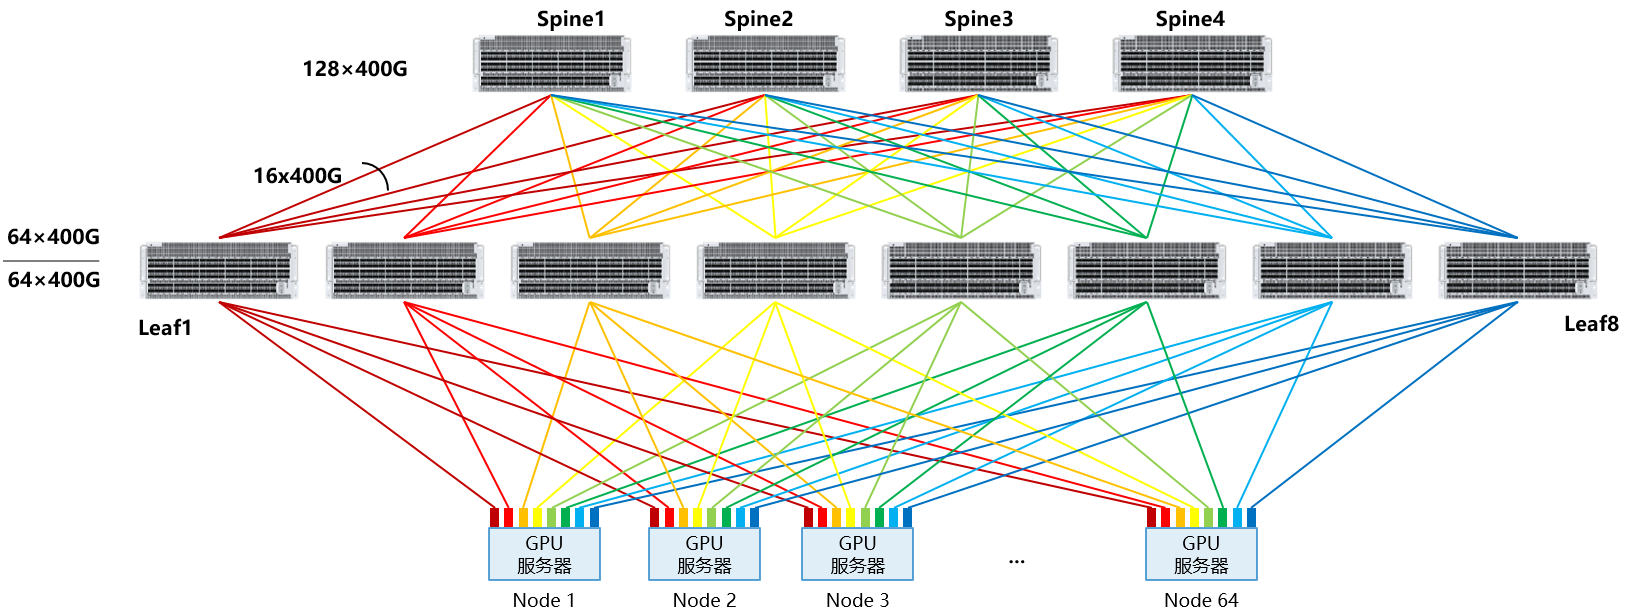

None


In [72]:
# 初始化
table = None
image_b64_roce = image2b64("./RoCEimage/roce05.png")

#展示读取的图片
from PIL import Image
display(Image.open("./RoCEimage/roce14.png"))

#将上面图片转为字符串
#user_input = "show this table in string"
#chart_agent(image_b64_roce, user_input, table)
#print(table)    # let's see what 'table' looks like now

# 让Agnet尝试解释图片的含义
user_input = "Please help me analyze and explain the meaning of this picture,And translate it into Chinese output"
chart_agent(image_b64_roce, user_input, table)
print(table) 

# 生成代码绘图
#user_input = "draw this table as stacked bar chart in python"
# user_input = "Please help me analyze and explain the meaning of this picture,And translate it into Chinese output"
#result = chart_agent(image_b64_roce, user_input, table)
#print("result: "+result)  # let's see what 'table' looks like now

# 功能3：大模型分析mp4视频,RAG AI Agent回复用户问题

In [29]:
# 把本地目录下grok3.mp4文件，将视频文件转换为音频文件，使用 Whisper 模型进行转录，将转录结果保存到文件grok3.txt
import moviepy.editor as mp
import whisper

def video_to_audio(video_path, audio_path):
    """
    将视频文件转换为音频文件
    :param video_path: 视频文件的路径
    :param audio_path: 音频文件的输出路径
    """
    try:
        video = mp.VideoFileClip(video_path)
        audio = video.audio
        audio.write_audiofile(audio_path)
        audio.close()
        video.close()
        print(f"成功将视频转换为音频，保存路径: {audio_path}")
    except Exception as e:
        print(f"视频转音频时出错: {e}")


def transcribe_audio(audio_path, output_path):
    """
    使用 Whisper 模型对音频文件进行转录，并将结果保存到文件中
    :param audio_path: 音频文件的路径
    :param output_path: 转录结果的输出文件路径
    """
    try:
        # 加载 Whisper 模型，这里使用 base 模型，你可以根据需要选择其他模型
        # model = whisper.load_model("tiny")
        #model = whisper.load_model("base")
        model = whisper.load_model("large")
        # Whisper 模型有不同的大小和性能，tiny 模型速度快但准确率可能稍低，large 模型准确率高但需要更多的计算资源和时间。
        # 进行转录
        result = model.transcribe(audio_path)
        transcription = result["text"]
        # 将转录结果保存到文件中
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(transcription)
        print(f"成功转录音频，结果保存路径: {output_path}")
    except Exception as e:
        print(f"音频转录时出错: {e}")


if __name__ == "__main__":
    video_path = "grok3.mp4"
    audio_path = "grok3.wav"
    output_path = "grok3.txt"

    # 视频转音频
    video_to_audio(video_path, audio_path)
    # 音频转录
    transcribe_audio(audio_path, output_path)

MoviePy - Writing audio in grok3.wav


MoviePy - Done.
成功将视频转换为音频，保存路径: grok3.wav
成功转录音频，结果保存路径: grok3.txt


In [31]:
# import moviepy.editor as mp
# import whisper
# import os

# def video_to_audio(video_path, audio_path):
#     """
#     将视频文件转换为音频文件
#     :param video_path: 视频文件的路径
#     :param audio_path: 音频文件的输出路径
#     """
#     try:
#         video = mp.VideoFileClip(video_path)
#         audio = video.audio
#         audio.write_audiofile(audio_path)
#         audio.close()
#         video.close()
#         if os.path.exists(audio_path):
#             file_size = os.path.getsize(audio_path)
#             print(f"成功将视频转换为音频，保存路径: {audio_path}，文件大小: {file_size} 字节")
#         else:
#             print(f"音频文件 {audio_path} 未成功生成。")
#     except Exception as e:
#         print(f"视频转音频时出错: {e}")


# def transcribe_audio(audio_path, output_path):
#     """
#     使用 Whisper 模型对音频文件进行转录，并将结果保存到文件中
#     :param audio_path: 音频文件的路径
#     :param output_path: 转录结果的输出文件路径
#     """
#     # 对路径进行规范化处理
#     absolute_audio_path = os.path.normpath(os.path.abspath(audio_path))
#     try:
#         if not os.path.exists(absolute_audio_path):
#             print(f"音频文件 {absolute_audio_path} 不存在，请检查。")
#             return
#         # 加载 Whisper 模型，这里使用 base 模型，你可以根据需要选择其他模型
#         model = whisper.load_model("base")
#         # 进行转录
#         result = model.transcribe(absolute_audio_path)
#         transcription = result["text"]
#         # 将转录结果保存到文件中
#         with open(output_path, "w", encoding="utf-8") as f:
#             f.write(transcription)
#         print(f"成功转录音频，结果保存路径: {output_path}")
#     except Exception as e:
#         print(f"音频转录时出错: {e}")


# if __name__ == "__main__":
#     video_path = "grok3.mp4"
#     audio_path = "grok3.wav"
#     output_path = "3grok3.txt"

#     # 视频转音频
#     video_to_audio(video_path, audio_path)
#     # 音频转录
#     transcribe_audio(audio_path, output_path)

MoviePy - Writing audio in grok3.wav


MoviePy - Done.
成功将视频转换为音频，保存路径: grok3.wav，文件大小: 446355582 字节
成功转录音频，结果保存路径: grok3.txt


In [10]:
#  实现RAG检索流程
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss
import os              #导入os模块，该模块提供了与操作系统进行交互的功能，比如文件和目录操作。
from tqdm import tqdm    #导入tqdm库中的tqdm函数，tqdm可以在循环中显示进度条，让用户直观地了解循环的执行进度。
from pathlib import Path   #导入pathlib模块中的Path类，Path类提供了一种面向对象的方式来处理文件系统路径。

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("./")    #使用os.listdir()函数获取当前目录（.表示当前目录）下的所有文件和文件夹的名称，并将这些名称存储在列表ps中
data = []     # 创建一个空列表data，用于存储从文本文件中读取的所有有效行。
sources = []  # 创建一个空列表sources，用于存储每一行数据对应的文件路径。
for p in ps:  # 遍历列表ps中的每个文件或文件夹名称
    if p.endswith('.txt'):  # 检查当前文件或文件夹名称是否以.txt结尾，如果是，则表示这是一个文本文件，需要进行处理。
        path2file="./"+p    # 构建当前文本文件的完整路径，将当前目录（./）和文件名拼接起来。
        with open(path2file,encoding="utf-8") as f:  # 使用open()函数以 UTF - 8 编码打开当前文本文件，并将文件对象赋值给变量f。with语句会在文件使用完毕后自动关闭文件。
            lines=f.readlines()  # 使用readlines()方法读取文件中的所有行，并将这些行存储在列表lines中。 
            for line in lines:   # 遍历列表lines中的每一行。
                if len(line)>=1:  # 检查当前行的长度是否大于等于 1，如果是，则表示这是一个有效行。
                    data.append(line)  # 将有效行添加到列表data中。
                    sources.append(path2file)  # 将当前行对应的文件路径添加到列表sources中。

documents=[d for d in data if d != '\n']
len(data), len(documents), data[0],data[-1]
# 这行代码实际上是一个元组，它分别计算了列表 data 的长度、列表 documents 的长度，并且获取了列表 data 的第一个元素,data 的最后一个元素。

from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings #langchain_nvidia_ai_endpoints 是一个自定义的 Python 模块，可能是由 NVIDIA 相关团队开发并集成到 langchain 生态系统中的。langchain 是一个用于开发由语言模型驱动的应用程序的框架，支持各种语言模型和工具的集成。NVIDIAEmbeddings 是从 langchain_nvidia_ai_endpoints 模块中导入的一个类。这个类通常用于将文本数据转换为向量表示，也就是文本嵌入（embeddings）。文本嵌入是将文本转换为数值向量的过程，这些向量可以用于各种自然语言处理任务，如文本相似度计算、信息检索、聚类等。

#embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")
embedder = NVIDIAEmbeddings(model="NV-Embed-QA")  #是传递给 NVIDIAEmbeddings 类构造函数的一个参数，它指定了要使用的嵌入模型。NV-Embed-QA 是 NVIDIA 提供的一个专门用于问答任务（QA，Question - Answering）的嵌入模型。当你调用 embedder 对象的相关方法时，它会使用 NV-Embed-QA 模型将输入的文本转换为对应的向量表示。

# 只需要执行一次，后面可以重读已经保存的向量存储
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
# CharacterTextSplitter 是 langchain 库中用于按字符进行文本分割的工具类。
# chunk_size=400：指定每个分割块的最大字符数为 400。即文本会被分割成字符数不超过 400 的小块。
# separator=" "：指定分割文本时使用的分隔符为空格。当分割文本时，会尽量以空格为界限来划分出不超过 400 字符的块。
docs = []  # docs：用于存储分割后的文本块。
metadatas = []  # metadatas：用于存储每个文本块对应的元数据，这里的元数据主要是文本块的来源信息。

for i, d in enumerate(documents):          # 使用 enumerate 函数遍历 documents 列表，i 是当前文档的索引，d 是当前文档的内容。
    splits = text_splitter.split_text(d)   # 调用 text_splitter 的 split_text 方法，将当前文档 d 分割成多个小块，结果存储在 splits 列表中。
    #print(len(splits))
    docs.extend(splits)    # 将分割后的文本块添加到 docs 列表中。
    metadatas.extend([{"source": sources[i]}] * len(splits))  # 为每个分割后的文本块生成对应的元数据，元数据是一个字典，键为 "source"，值为该文本块原始文档的来源（存储在 sources 列表中）。[{"source": sources[i]}] * len(splits) 会生成与分割后的文本块数量相同的元数据列表，然后将其添加到 metadatas 列表中。

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)   
store.save_local('./nv_embedding')

# FAISS 是一个用于高效相似性搜索和聚类的开源库，这里使用 langchain 对其进行了封装。
# FAISS.from_texts 是一个类方法，用于从文本列表构建 FAISS 向量索引。
# docs：输入的文本列表，即分割后的文本块。
# embedder：之前创建的嵌入器实例，用于将文本转换为向量表示。
# metadatas：每个文本块对应的元数据列表。
# 调用 store 对象的 save_local 方法，将构建好的 FAISS 向量索引保存到本地的 ./nv_embedding 目录下。后续可以从该目录加载索引进行相似性搜索等操作。
# 综上所述，这段代码的整体作用是将原始文本数据进行分割、向量化，并构建向量索引保存到本地，以便后续进行高效的文本搜索和检索。


#llm = ChatNVIDIA(model="ai-llama3-70b")
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

# 这行代码的主要功能是创建一个基于 NVIDIA 相关技术的大语言模型实例 llm，并且指定使用的具体模型为 "meta/llama3-70b-instruct"。该实例可以用于后续的文本生成、问答等自然语言处理任务。
# model="meta/llama3-70b-instruct" 参数
# model：这是传递给 ChatNVIDIA 类构造函数的一个重要参数，用于指定要使用的具体大语言模型。
# "meta/llama3-70b-instruct"：
# "meta" 通常表示该模型由 Meta（原 Facebook）公司开发。Meta 在自然语言处理领域有诸多研究和贡献，开发了许多知名的大语言模型。
# "llama3" 表明使用的是 Llama 系列的第三代模型。Llama 模型以其强大的语言理解和生成能力而受到广泛关注。
# "70b" 代表该模型具有 700 亿个参数。一般来说，模型的参数数量越多，其学习能力和表达能力就越强，能够处理更复杂的语言任务和生成更高质量的文本。
# "instruct" 说明这是一个经过指令微调的模型。经过指令微调的模型能够更好地理解用户以指令形式给出的任务描述，并按照指令生成相应的输出，例如回答问题、完成文本续写、进行文本摘要等。

# 创建检索器
retriever = store.as_retriever()
# store 是之前使用 FAISS.from_texts 方法构建的向量索引对象。
# as_retriever() 是 store 对象的一个方法，它将向量索引转换为一个检索器 retriever。检索器的作用是根据输入的查询文本，在向量索引中查找与之最相似的文本块。

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)
# ChatPromptTemplate 是 langchain 库中用于创建聊天提示模板的类。
# from_messages 是该类的一个类方法，用于从消息列表创建提示模板。消息列表中的每个元素是一个元组，包含消息的角色（如 "system" 或 "user"）和消息内容。
# "system" 消息是系统级别的提示信息，告诉大语言模型回答问题时仅基于提供的上下文信息。{context} 是一个占位符，后续会被检索到的相关文本块填充。
# "user" 消息是用户提出的问题，{question} 是一个占位符，会被实际的问题文本替换。



chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
# 这里使用了 langchain 的链式调用语法，将多个组件组合成一个处理链。
# {"context": retriever, "question": RunnablePassthrough()}：这是一个字典，用于将输入数据进行分发。"context" 键对应的值是 retriever，表示将输入的问题传递给检索器，检索器会返回相关的文本块作为上下文；"question" 键对应的值是 RunnablePassthrough()，表示将输入的问题原样传递下去。
# | prompt：将分发后的数据传递给提示模板 prompt，提示模板会根据占位符 {context} 和 {question} 填充相应的内容，生成完整的提示信息。
# | llm：将填充好的提示信息传递给大语言模型 llm，大语言模型根据提示信息生成答案。
# | StrOutputParser()：将大语言模型生成的输出解析为字符串类型。


#chain.invoke("Malaysia 2023 Growth？")
#chain.invoke("China 2023 Growth？")
#chain.invoke("Indonesia 2023 Growth？")
#chain.invoke("g18 节点的内存使用率是多少？")
#chain.invoke("What is the CPU usage rate of node g18?")
#chain.invoke("Which command belongs to test05?？")
chain.invoke("How many days after the construction of the world's most powerful training cluster will be put into operation?")
# invoke 是处理链 chain 的一个方法，用于启动整个处理流程。
#传入的 "China 2023 Growth？" 是用户提出的问题，处理链会先使用检索器查找相关的上下文，然后将上下文和问题填充到提示模板中，再将提示信息传递给大语言模型生成答案，最后将答案解析为字符串并返回。
# 综上所述，这段代码实现了一个完整的问答系统，利用向量索引检索相关信息，结合大语言模型生成基于上下文的问题答案。

# 这段代码主要实现了一个基于检索增强生成（RAG）的问答系统，利用之前构建的向量索引来检索相关信息，并结合大语言模型生成问题的答案。

# 检索后回复："The world's most powerful training cluster was operational within 122 days. There is no information about how many days after construction it will be put into operation. It was already operational within 122 days."
# RAG检索后回复：“世界上最强大的训练集群在 122 天内投入使用。没有关于施工后多少天将投入运营的信息。它在 122 天内就已经投入使用。

"The world's most powerful training cluster was operational within 122 days. There is no information about how many days after construction it will be put into operation. It was already operational within 122 days."

In [9]:
#pip install chardet
# import chardet

# #file_path = 'your_file.txt'  # 替换为实际的文件路径
# file_path = 'requirements.txt'  # 替换为实际的文件路径
# with open(file_path, 'rb') as f:
#     raw_data = f.read()
#     result = chardet.detect(raw_data)
#     encoding = result['encoding']
#     print(f"检测到的文件编码为: {encoding}")
# 由于这个文件检测到的文件编码为: UTF-16
# 而且不是我们需要检索内容的txt文件，所以需要挪到其他文件夹。
    

检测到的文件编码为: UTF-16
